In [1]:
import os
import re
import sys

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

from scipy import stats

import math

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from copy import deepcopy
import logging as log

import pickle
import xlrd, xlwt
import pylab

In [2]:
# Helper (support)
from support import input_helper

In [3]:
# Directory with IGU datasets:
ROOT_DIR = "RawData"

# Specify path to dynamic stock model and to datafile, relative
MainPath = os.path.join('odym', 'modules')
DataPath = os.path.join('docs', 'files')
sys.path.insert(0, MainPath)  # add ODYM module directory to system path

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))
sys.path.insert(0, os.path.join(os.getcwd(), 'docs', 'files'))

# Define path to save figures:
path_img = (
    r'C:\Users\souvi\Documents\These\90_Presentations & Writting\50_Papers\2021_12_MEFA of IGU\IMG'
)

In [4]:
import ODYM_Classes as msc  # import the ODYM class file
import ODYM_Functions as msf  # import the ODYM function file
import dynamic_stock_model as dsm  # import the dynamic stock model library

In [5]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 10)

In [6]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.5,
                rc={"axes.titlesize": 15, "lines.linewidth": 1.2,
                    "legend.fontsize": 10, "legend.title_fontsize": 10})

In [7]:
pd.set_option('precision', 2)

In [8]:
# A custom formatter function which divide by 1000 an axis:
def yfmt1000(x, pos): 
    s = f'{x/1000:,.1f}'
    return s

# W/ classes for tick-locating and -formatting:
import matplotlib.ticker as tkr

# A formatter function:
y_1000 = tkr.FuncFormatter(yfmt1000)

# To divide the y-axis by 1000 when needed:
# ax.yaxis.set_major_formatter(y_1000)

In [9]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

In [10]:
# A keyword to export figures, or not:
export = False

# Upload Datasets

In [11]:
be_data = input_helper.get_data(
    'BE_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)
fr_data = input_helper.get_data(
    'FR_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)
eu_data = input_helper.get_data(
    'eu_igu_RawData_VPython.xlsx', directory=ROOT_DIR)

In [12]:
print("be_data, sheet names = \n {}\n".format(be_data.sheet_names))
print("fr_data, sheet names = \n {}\n".format(fr_data.sheet_names))
print("eu_data, sheet names = \n {}\n".format(eu_data.sheet_names))

be_data, sheet names = 
 ['prod', 'import', 'export', 'Population']

fr_data, sheet names = 
 ['References', 'prod', 'import', 'export', 'Population', 'MatEnergy_WindowGlass', 'MatEnergy_PlateGlass', 'RawMat_Intensity', 'Energy_Intensity', 'emissions']

eu_data, sheet names = 
 ['stock', 'prod', 'import', 'export']



# Material, Energy and Carbon Intensity in the Flat Glass Industry

See: Souviron and Khan. (Forthcoming). "The Materiality of Transparency: An Environmental Analysis of the Architectural Flat Glass Industry since 1945 in Europe, France and Belgium". Resources, Conservation and Recycling.

## Material intensity since 1945

In [13]:
# Create a DataFrame for material intensity:
mat_intensity = fr_data.parse('RawMat_Intensity').set_index('year')

mat_intensity['cullet, kg/kg'] = (mat_intensity['internal cullet, kg/kg']
                                  + mat_intensity['external cullet, kg/kg'])

In [14]:
# List of raw materials:
materials = ['sand', 'cullet', 'sodium carbonate',
             'limestone', 'dolomite', 'feldspar']

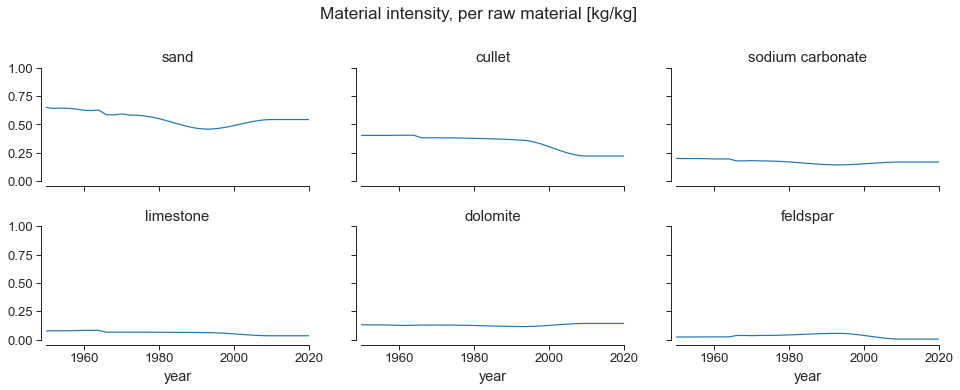

In [15]:
# Plot raw materials intensity since 1945:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    ax.set_title(mat)
    (mat_intensity[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax)
     )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("Material intensity, per raw material [kg/kg]", y=1.05)
fig.subplots_adjust(hspace=0.4)

sns.despine(offset=5)
plt.show()

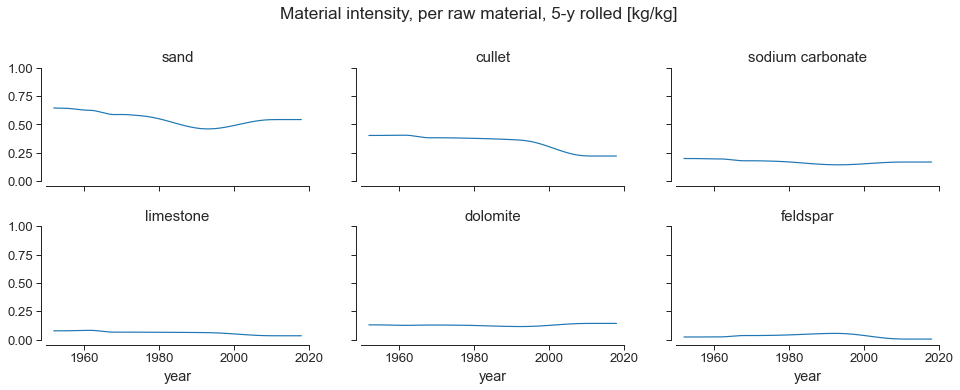

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    ax.set_title(mat)
    (mat_intensity[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("Material intensity, per raw material, 5-y rolled [kg/kg]",
             y=1.05)
fig.subplots_adjust(hspace=0.4)

sns.despine(offset=5)
plt.show()

In [17]:
# Estimate the material intensity (sum of the intenisities per material):
mat_intensity['Total raw materials, kg/kg'] = 0

for mat in materials:
    mat_intensity['Total raw materials, kg/kg'] = (
        mat_intensity[f"{mat}, kg/kg"]
        + mat_intensity['Total raw materials, kg/kg']
    )

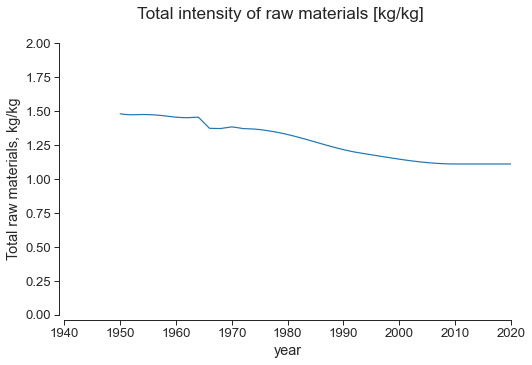

In [18]:
# Plot the material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=mat_intensity,
             x=mat_intensity.index,
             y=(mat_intensity['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax)

ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw materials [kg/kg]")

sns.despine(offset=5)
plt.show()

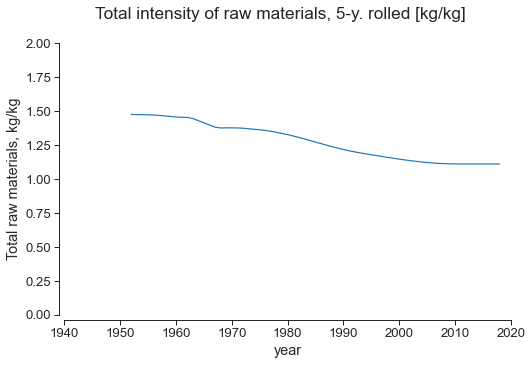

In [19]:
# Plot a 5-y rolled material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=mat_intensity,
             x=mat_intensity.index,
             y=(mat_intensity['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax)

ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw materials, 5-y. rolled [kg/kg]")

sns.despine(offset=5)
plt.show()

In [20]:
matwocullet = ['sand', 'sodium carbonate', 'limestone',
               'dolomite', 'feldspar']

In [21]:
# Estimate the material intensity without cullet:
mat_intensity['Total raw mat w/o cullet, kg/kg'] = 0

for mat in matwocullet:
    mat_intensity['Total raw mat w/o cullet, kg/kg'] = (
        mat_intensity[f"{mat}, kg/kg"]
        + mat_intensity['Total raw mat w/o cullet, kg/kg']
    )

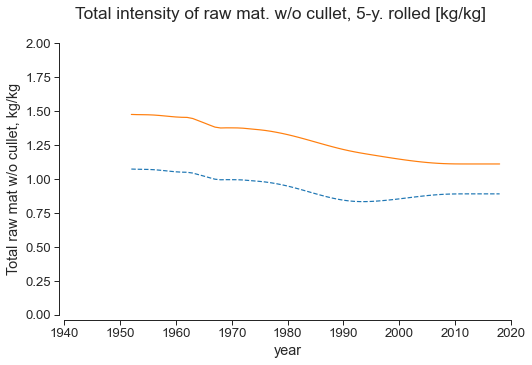

In [22]:
# Plot a 5-y rolled material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=mat_intensity,
             x=mat_intensity.index,
             y=(mat_intensity['Total raw mat w/o cullet, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax, linestyle='--')

sns.lineplot(data=mat_intensity,
             x=mat_intensity.index,
             y=(mat_intensity['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax)

ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw mat. w/o cullet, 5-y. rolled [kg/kg]")

sns.despine(offset=5)
plt.show()

## Energy Intensity since 1945

In [23]:
# Create a DataFrame for energy intensity:
energy_intensity = fr_data.parse('Energy_Intensity').set_index('year')

In [24]:
energies = ['fuel oil', 'natural gas', 'electricity']

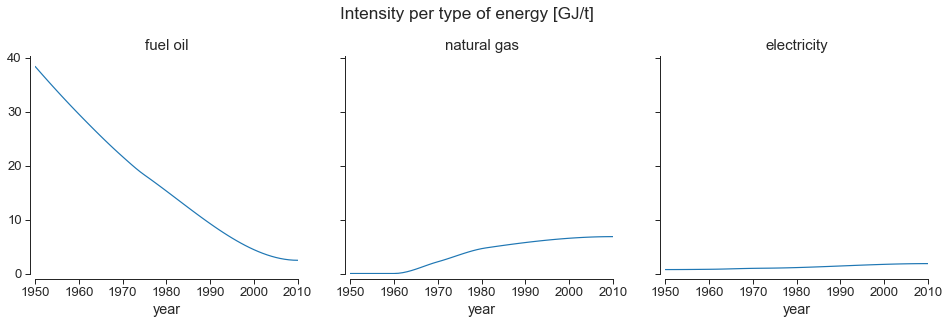

In [25]:
# Plot the intensity per type of energy:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    (energy_intensity[f"{energy}, GJ/t"]  # Interpolate:
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax))

ax.set_xlim(1950, 2010)
ax.set_ylim(ymin=0)

fig.suptitle("Intensity per type of energy [GJ/t]", y=1.05)

sns.despine(offset=5)
plt.show()

In [26]:
# Estimate the energy intensity (sum of the intensities per type of energy):
energy_intensity['Total energy, GJ/t'] = 0

for energy in energies:
    energy_intensity['Total energy, GJ/t'] = (
        energy_intensity['Total energy, GJ/t']
        + energy_intensity[f"{energy}, GJ/t"]
    )

In [27]:
fossilfuels = ['fuel oil', 'natural gas']

In [28]:
# Estimate the energy intensity (sum of the intensities per type of energy):
energy_intensity['Total energy w/o elec., GJ/t'] = 0

for energy in fossilfuels:
    energy_intensity['Total energy w/o elec., GJ/t'] = (
        energy_intensity['Total energy w/o elec., GJ/t']
        + energy_intensity[f"{energy}, GJ/t"]
    )

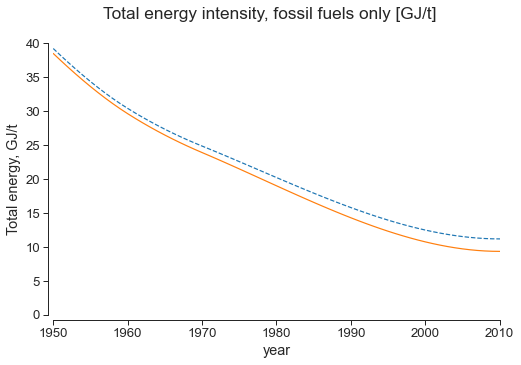

In [29]:
# Plot the total energy intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=energy_intensity,
             x=energy_intensity.index,
             y=(energy_intensity['Total energy, GJ/t']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax, linestyle='--')

sns.lineplot(data=energy_intensity,
             x=energy_intensity.index,
             y=(energy_intensity['Total energy w/o elec., GJ/t']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax)

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 40)

fig.suptitle("Total energy intensity, fossil fuels only [GJ/t]")

sns.despine(offset=5)
plt.show()

##  Carbon Intensity of the Flat Glass Production Process

In [30]:
# Create a DataFrame only with the CO2 emission data:
emissions = fr_data.parse('emissions').set_index('year')

co2_intensity = emissions[['CO2 glass ind, kg/t']].copy()
co2_intensity.rename(columns={'CO2 glass ind, kg/t': 'CO2 [kg/t]'},
                     inplace=True)

co2_intensity.dropna()

,CO2 [kg/t]
year,
1947,2100.0
1950,2050.0
1960,1725.0
1965,1525.0
1970,1340.0
1975,1075.0
1980,900.0
1985,800.0
1990,690.0


In [31]:
# Interpolate co2 intensity accoring to a pchip method:
co2_intensity['CO2 interpolated [kg/t]'] = (
    co2_intensity['CO2 [kg/t]'].interpolate('pchip')
)

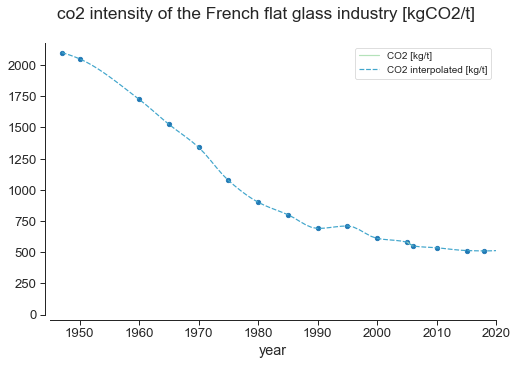

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=co2_intensity, palette="GnBu")

ax.scatter(x=co2_intensity.index, y=co2_intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)
fig.suptitle("co2 intensity of the French flat glass industry [kgCO2/t]")
sns.despine(offset=5)
plt.show()

## Summary

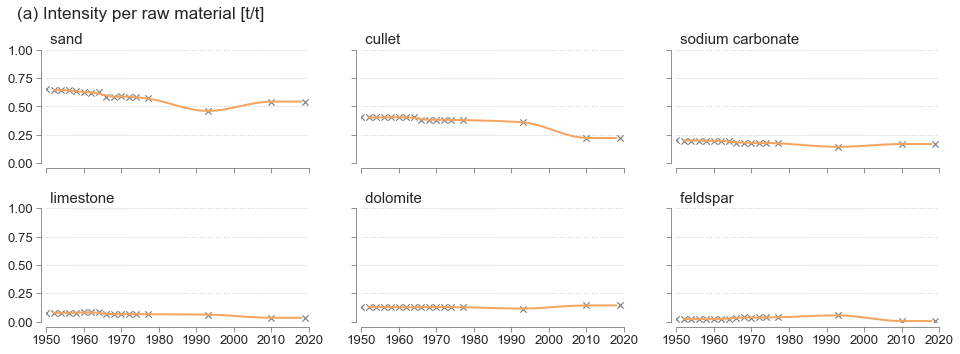

In [33]:
# Plot the material instensity per raw material:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    (mat_intensity[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c='sandybrown', linewidth=2))

    ax.scatter(x=mat_intensity.index, y=mat_intensity[f"{mat}, kg/kg"],
               s=40, marker='x', c='grey')
    plt.xticks(np.arange(1950, 2021, 10), rotation=45)

    ax.set_title(f" {mat}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(a) Intensity per raw material [t/t]", x=0.1, y=1, ha='left')
fig.subplots_adjust(wspace=0.2, hspace=0.4)

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig4_Mat Intensity.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig4_Mat Intensity.pdf'),
                bbox_inches='tight')

plt.show()

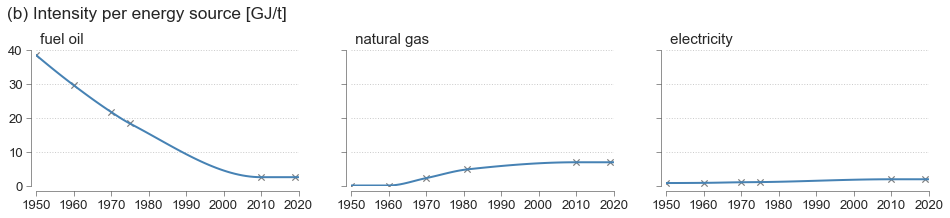

In [34]:
# Plot the energy intensity per source of energy:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5)
                         )

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    (energy_intensity[f"{energy}, GJ/t"]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax, color='steelblue', linewidth=2))

    ax.scatter(x=energy_intensity.index, y=energy_intensity[f"{energy}, GJ/t"],
               s=40, marker='x', c='grey')

    ax.set_title(f" {energy}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)

fig.suptitle("(b) Intensity per energy source [GJ/t]",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.2)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig4_Energy Intensity.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig4_Energy Intensity.pdf'),
                bbox_inches='tight')

plt.show()

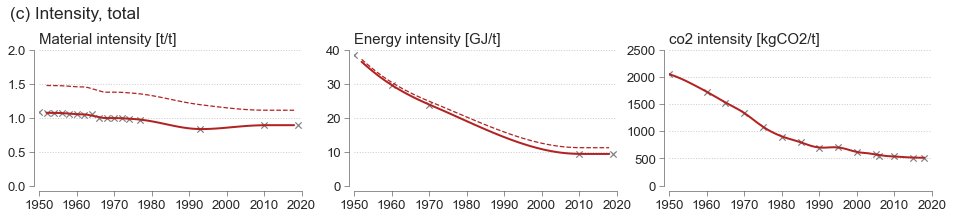

In [35]:
# Plot the intensity for energy, material and CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Material intensity
ax = axes[0]
(mat_intensity['Total raw materials, kg/kg']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25)
 )

(mat_intensity['Total raw mat w/o cullet, kg/kg']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='-', linewidth=2)
 )

ax.scatter(x=mat_intensity.index,
           y=mat_intensity['Total raw mat w/o cullet, kg/kg'],
           s=40, marker='x', c='grey')

ax.set_title("Material intensity [t/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 2)
ax.set_xlim(1950, 2020)

# Energy intensity
ax = axes[1]
(energy_intensity['Total energy, GJ/t']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25))

(energy_intensity['Total energy w/o elec., GJ/t']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=energy_intensity.index,
           y=energy_intensity['Total energy w/o elec., GJ/t'],
           s=40, marker='x', c='grey')

ax.set_title("Energy intensity [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)

# Carbon dioxide intensity
ax = axes[2]
(co2_intensity['CO2 interpolated [kg/t]'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=co2_intensity.index, y=co2_intensity['CO2 [kg/t]'],
           s=40, marker='x', c='grey')

ax.set_title("co2 intensity [kgCO2/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 2500)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(c) Intensity, total", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.20)

sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig4_TotalIntensity.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig4_TotalIntensity.pdf'),
                bbox_inches='tight')

plt.show()

# Flows of Insulating Glass Units in Europe

## Creating a Dataframe for the Flows of IGU

In [36]:
# Data relating to IGU production:
eu_prod = eu_data.parse('prod').set_index(['Nbr of countries', 'year'])

In [37]:
# Add import and export flows:
eu_imp = eu_data.parse('import').set_index(['Nbr of countries', 'year'])
eu_exp = eu_data.parse('export').set_index(['Nbr of countries', 'year'])

In [38]:
# Create a new DataFrame for European IGU flows:
eu_igu = pd.concat([eu_prod['IGU, "000 m²']/1000,
                    eu_imp['IGU, "000 m²']/1000,
                    eu_exp['IGU, "000 m²']/1000],
                   axis=1, keys=[('Production', '[10^6 m²]'),
                                 ('Import', '[10^6 m²]'),
                                 ('Export', '[10^6 m²]')],
                   names=['Info', 'Unit']).stack(dropna=False)

eu_igu = eu_igu.unstack()

In [39]:
eu_igu.style

In [40]:
# Adding columns for data in [kt],
# to be used later for material/energy/carbon intensity
# 2500kg/m³ and in average 9mm thick

eu_igu[('Production', '[kt]')] = eu_igu[('Production', '[10^6 m²]')] * 2.5 * 9
eu_igu[('Import', '[kt]')] = eu_igu[('Import', '[10^6 m²]')] * 2.5 * 9
eu_igu[('Export', '[kt]')] = eu_igu[('Export', '[10^6 m²]')] * 2.5 * 9

eu_igu = eu_igu.sort_index(axis=1)

In [41]:
eu_igu

Info                     Export           Import        Production         
Unit                  [10^6 m²]   [kt] [10^6 m²]   [kt]  [10^6 m²]     [kt]
Nbr of countries year                                                      
6                1945       NaN    NaN       NaN    NaN        NaN      NaN
                 1946       NaN    NaN       NaN    NaN        NaN      NaN
                 1947      0.00   0.00      0.00   0.00       0.00     0.00
                 1948       NaN    NaN       NaN    NaN        NaN      NaN
                 1949       NaN    NaN       NaN    NaN        NaN      NaN
...                         ...    ...       ...    ...        ...      ...
28               2015      2.83  63.76      0.87  19.66     116.00  2610.00
                 2016      2.94  66.18      1.00  22.54     114.00  2565.00
                 2017      3.41  76.65      2.12  47.64     121.60  2736.00
                 2018      3.20  71.90      1.02  22.95     117.01  2632.76
                 2019      3.42  76.85      2.32  52.15     121.06  2723.88

[77 rows x 6 columns]

## Production of Insulating Glass Units

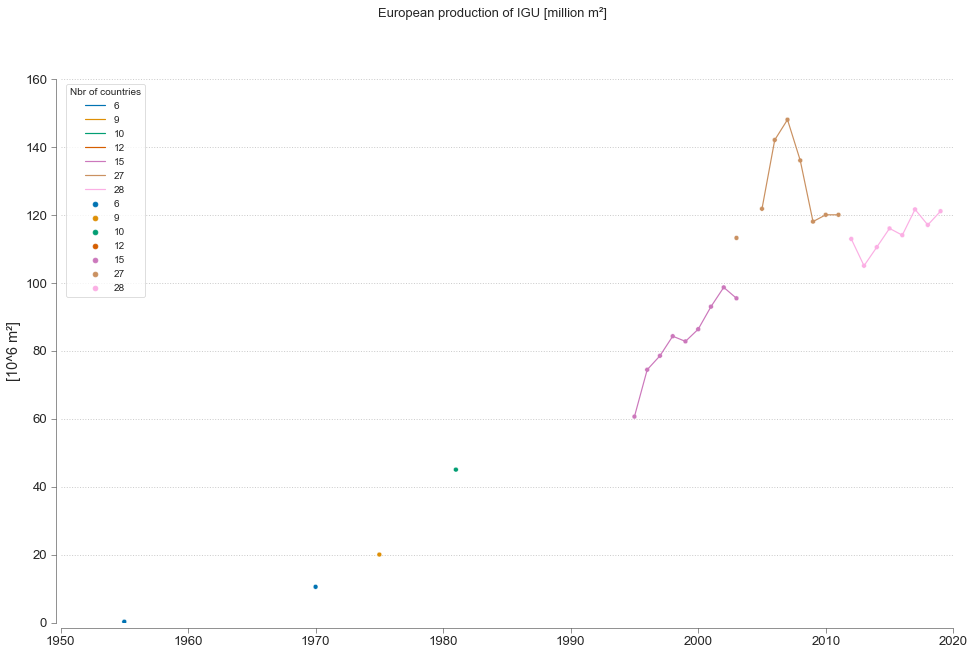

In [42]:
# Plot the European production of IGU
fig, ax = plt.subplots()

sns.scatterplot(data=eu_igu['Production'].reset_index(),
                x='year', y='[10^6 m²]',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

sns.lineplot(data=eu_igu['Production'].reset_index(),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)

fig.suptitle('European production of IGU [million m²]', fontsize=13)
sns.despine(offset=5)
plt.show()

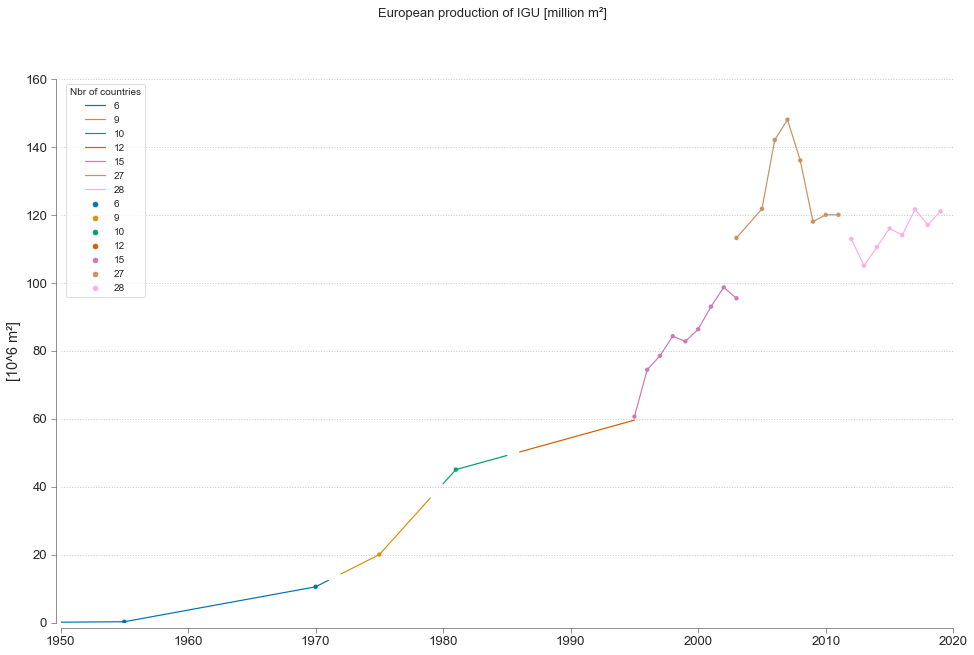

In [43]:
# Plot the European production of IGU:
fig, ax = plt.subplots()

sns.scatterplot(data=eu_igu['Production'].reset_index(),
                x='year', y='[10^6 m²]',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

sns.lineplot(data=(eu_igu['Production']
                   .interpolate(method='linear').reset_index()),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)

fig.suptitle('European production of IGU [million m²]', fontsize=13)
sns.despine(offset=5)
plt.show()

## Consumption of Insulating Glass Units

In [44]:
# Estimate the consumption of IGU in the EU:
eu_igu = eu_igu.stack(dropna=False)

eu_igu['Consumption'] = (eu_igu['Production']
                         + eu_igu['Import']
                         - eu_igu['Export']
                         )

eu_igu = eu_igu.unstack()

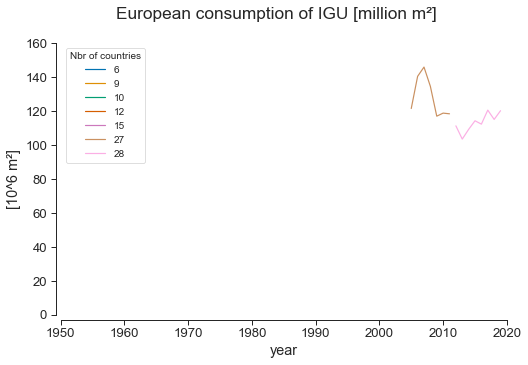

In [45]:
# Plot the European consumption of IGU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_igu['Consumption'].reset_index(),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

fig.suptitle('European consumption of IGU [million m²]')
sns.despine(offset=5)
plt.show()

## Summary

In [46]:
# Key dates for the changes in the MFA scope, i.e. EU enlargement:
eu_kdates = {'EU6': 1972, 'EU10': 1980, 'EU12': 1986,
             'EU15': 1995, 'EU27': 2003, 'EU28': 2012}

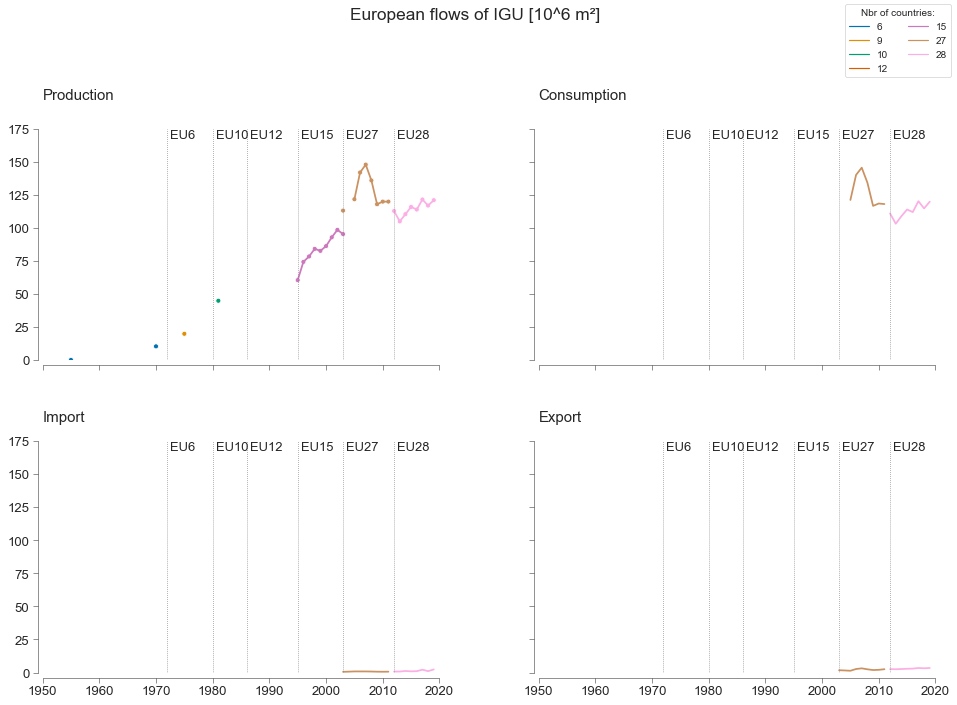

In [47]:
# Plot a synthesis of the results concerning European flows of IGU:
data1 = ['Production', 'Consumption']
data2 = ['Import', 'Export']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

# Plot production and consumption:
for col, data in enumerate(data1):
    ax = axes[0][col]
    sns.lineplot(data=eu_igu[f"{data}"].reset_index(),
                 x='year', y="[10^6 m²]",
                 hue='Nbr of countries',
                 palette='colorblind', linewidth=1.75,
                 ax=ax)

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in eu_kdates.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 175, f"{y}", fontsize=13,
                verticalalignment='top')

    if col == 0:
        # Plot data gathered from literature review:
        sns.scatterplot(data=eu_igu[f"{data}"].reset_index(),
                        x='year', y="[10^6 m²]",
                        hue='Nbr of countries',
                        palette='colorblind',
                        marker='.', s=100,
                        ax=ax)

    ax.get_legend().remove()
    style_ax(ax)

    ax.set_title(f"{data}", pad=30, loc='left')
    #ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    # ax.get_legend().remove()
    ax.yaxis.label.set_visible(False)

# Plot import and export below:
for col, data in enumerate(data2):
    ax = axes[1][col]
    sns.lineplot(data=eu_igu[f"{data}"].reset_index(),
                 x='year', y="[10^6 m²]",
                 hue='Nbr of countries',
                 palette='colorblind', linewidth=1.75,
                 ax=ax)

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in eu_kdates.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 175, f"{y}", fontsize=13,
                verticalalignment='top')

    style_ax(ax)

    ax.set_title(f"{data}", pad=20, loc='left')
    #ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.get_legend().remove()
    ax.yaxis.label.set_visible(False)


# Add legend:
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2,
           title='Nbr of countries:',
           bbox_to_anchor=(0.83, 0.98))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 175)

fig.suptitle("European flows of IGU [10^6 m²]", y=1.05)
fig.subplots_adjust(wspace=0.25, hspace=0.35)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixB_EU_IGUFlows.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixB_EU_IGUFlows.pdf'),
                bbox_inches='tight')

Hypothesis for missing data: EU production = EU consumption

In [48]:
eu_igu = eu_igu.stack(dropna=False)
eu_igu['Estimated consumption'] = (eu_igu['Consumption']
                                   .fillna(eu_igu['Production']))

eu_igu = eu_igu.unstack()

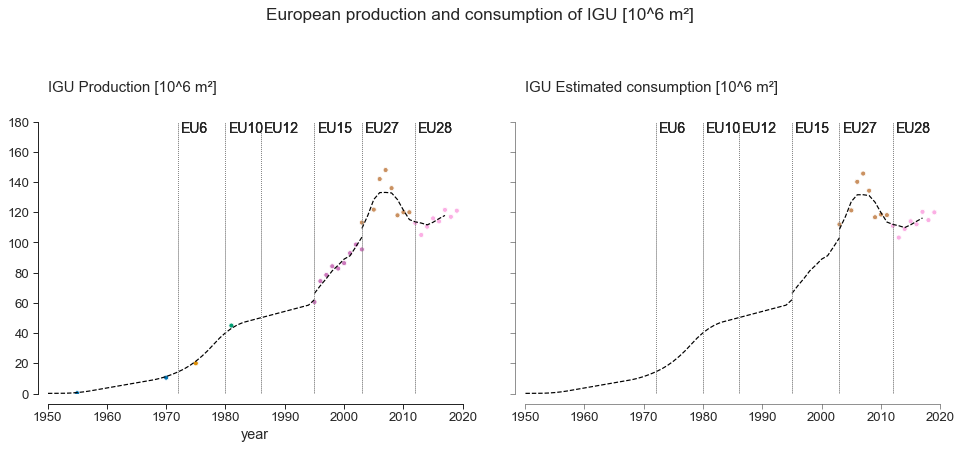

In [49]:
# Plot two figures:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

# Number of countries for trend curves:
eu_list = [(6, 12), (15, 15), (27, 28)]

for col, data in enumerate(['Production', 'Estimated consumption']):
    for i, j in eu_list:
        ax = axes[col]
        # Plot the trend curve for IGU production:
        ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[i:j]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{data}", "[10^6 m²]")],
                c='black', linestyle='--')

        if col == 0:
            # Plot data gathered from literature review:
            sns.scatterplot(data=eu_igu["Production"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)
        else:
            # Plot data gathered from literature review:
            sns.scatterplot(data=eu_igu["Consumption"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)
            
        # Plot lines highlighting changes in the scope, i.e., EU enlargement:
        for y, x in eu_kdates.items():
            ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
            ax.text(x+0.5, 180, f"{y}", fontsize=14,
                    verticalalignment='top')
            
        ax.get_legend().remove()
        ax.set_title(f'IGU {data} [10^6 m²]', pad=30, loc='left')
        ax.yaxis.label.set_visible(False)

style_ax(ax)
ax.set_xlim(1950, 2020)
ax.set_ylim(0, 180)

plt.suptitle('European production and consumption of IGU [10^6 m²]',
             weight='light', y=1.2)

fig.subplots_adjust(wspace=0.15)

sns.despine(offset=10)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig2_EU_IGUProdConso.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig2_EU_IGUProdConso.pdf'),
                bbox_inches='tight')

# Flows of Insulating Glass Units in France and Belgium

## Creating a Dataframe for the Flows of IGU

In [50]:
# Create a DataFrame only with production data:
fr_prod = fr_data.parse('prod').set_index('year')
be_prod = be_data.parse('prod').set_index('year')

In [51]:
# Create a DataFrame with import and export data:
fr_imp = fr_data.parse('import').set_index('year')
fr_exp = fr_data.parse('export').set_index('year')

be_imp = be_data.parse('import').set_index('year')
be_exp = be_data.parse('export').set_index('year')

In [52]:
# Create a DataFrame with import and export data:
fr_pop = fr_data.parse('Population').set_index('year')
be_pop = be_data.parse('Population').set_index('year')

In [53]:
# Create a unique DataFrame for French and Belgian population:
be_fr_pop = pd.concat([fr_pop['Population, x1000'],
                       be_pop['Population, x1000']],
                      axis=1, keys=[('Population [x1000]', 'France'),
                                    ('Population [x1000]', 'Belgium')],
                      names=['Info', 'Country']).stack()

be_fr_pop = be_fr_pop.unstack()

In [54]:
# Create a new DataFrame for Belgian and French IGU flows:
be_fr_igu = (
    pd.concat([fr_prod['IGU, kt'], be_prod['IGU, kt'],
               fr_prod['IGU, "000 m²']/1000, be_prod['IGU, "000 m²']/1000,
               fr_imp['IGU, kt'], be_imp['IGU, kt'],
               fr_imp['IGU, "000 m²']/1000, be_imp['IGU, "000 m²']/1000,
               fr_exp['IGU, kt'], be_exp['IGU, kt'],
               fr_exp['IGU, "000 m²']/1000, be_exp['IGU, "000 m²']/1000],
              axis=1,
              keys=[('Production', '[kt]', 'France'),
                    ('Production', '[kt]', 'Belgium'),
                    ('Production', '[10^6 m²]', 'France'),
                    ('Production', '[10^6 m²]', 'Belgium'),
                    ('Import', '[kt]', 'France'),
                    ('Import', '[kt]', 'Belgium'),
                    ('Import', '[10^6 m²]', 'France'),
                    ('Import', '[10^6 m²]', 'Belgium'),
                    ('Export', '[kt]', 'France'),
                    ('Export', '[kt]', 'Belgium'),
                    ('Export', '[10^6 m²]', 'France'),
                    ('Export', '[10^6 m²]', 'Belgium')],
              names=['Info', 'Unit', 'Country'])).stack(level=- 1,
                                                        dropna=False)

be_fr_igu = be_fr_igu.unstack()

In [55]:
be_fr_igu

Info       Export                          Import                        \
Unit    [10^6 m²]           [kt]        [10^6 m²]           [kt]          
Country   Belgium France Belgium France   Belgium France Belgium France   
year                                                                      
1945          NaN    NaN     NaN    NaN       NaN    NaN     NaN    NaN   
1946          NaN    NaN     NaN    NaN       NaN    NaN     NaN    NaN   
1947         0.00    NaN    0.00    NaN       NaN    NaN     NaN    NaN   
1948          NaN    NaN     NaN    NaN       NaN    NaN     NaN    NaN   
1949          NaN    NaN     NaN    NaN       NaN    NaN     NaN    NaN   
...           ...    ...     ...    ...       ...    ...     ...    ...   
2016         0.79   0.51   21.61  11.42      0.43   0.35    9.83   7.80   
2017         0.72   0.63   19.80  14.18      0.45   0.32   10.35   7.22   
2018         0.76   0.65   20.94  14.67      0.36   0.44    8.30   9.83   
2019          NaN   0.82     NaN  18.45      0.61   0.41   14.02   9.30   
2020          NaN    NaN     NaN    NaN       NaN    NaN     NaN    NaN   

Info    Production                         
Unit     [10^6 m²]           [kt]          
Country    Belgium France Belgium  France  
year                                       
1945           NaN    NaN     NaN     NaN  
1946          0.00   0.00    0.00    0.00  
1947           NaN    NaN     NaN     NaN  
1948           NaN    NaN     NaN     NaN  
1949           NaN    NaN     NaN     NaN  
...            ...    ...     ...     ...  
2016          3.95  15.19   88.80  341.82  
2017          4.19  15.70   94.33  353.18  
2018          4.12  16.46   92.80  370.41  
2019          4.35  17.21   97.86  387.15  
2020           NaN    NaN     NaN     NaN  

[76 rows x 12 columns]

## Production of Insulating Glass Units

In [56]:
countries = ['Belgium', 'France']

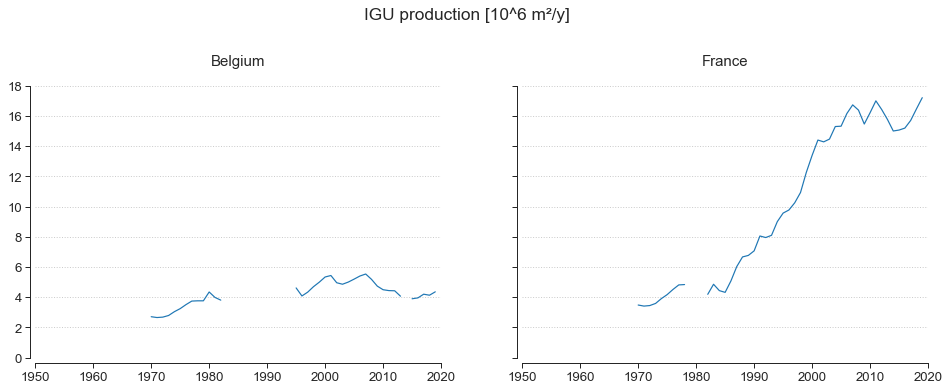

In [57]:
# Plot the BE and FR production of IGU:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr_igu.index,
            be_fr_igu[('Production', '[10^6 m²]')][country])

    ax.set_title(country, pad=20)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 18)

fig.suptitle('IGU production [10^6 m²/y]', y=1.1)
sns.despine(offset=5)
plt.show()

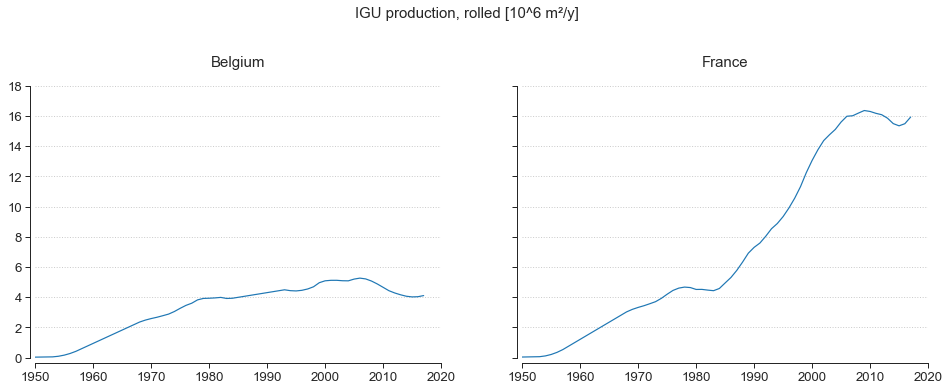

In [58]:
# Plot a moving average for IGU production:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr_igu.index,
            be_fr_igu[('Production', '[10^6 m²]')][country]
            # Linear interpolation for IGU production:
            .interpolate(method="linear", limit_area='inside')
            # Rolling IGU production according to a 5-year mean:
            .rolling(5, center=True).mean())

    ax.set_title(country, y=1.05)
    ax.set_xlim(1950, 2020)
    ax.set_ylim(0, 18)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

fig.suptitle('IGU production, rolled [10^6 m²/y]', fontsize=15, y=1.1)
sns.despine(offset=5)
plt.show()

## Consumption of Insulating Glass Units

In [59]:
# Caculate import and export ratios relative to production:
be_fr_igu = be_fr_igu.stack(level=[1, 2], dropna=False)

be_fr_igu['Import Ratio'] = (be_fr_igu['Import']
                             / be_fr_igu['Production'])
be_fr_igu['Export Ratio'] = (be_fr_igu['Export']
                             / be_fr_igu['Production'])

be_fr_igu = be_fr_igu.unstack(level=[1, 2])

In [60]:
be_fr_igu

Info       Export                          Import                        \
Unit    [10^6 m²]           [kt]        [10^6 m²]           [kt]          
Country   Belgium France Belgium France   Belgium France Belgium France   
year                                                                      
1945          NaN    NaN     NaN    NaN       NaN    NaN     NaN    NaN   
1946          NaN    NaN     NaN    NaN       NaN    NaN     NaN    NaN   
1947         0.00    NaN    0.00    NaN       NaN    NaN     NaN    NaN   
1948          NaN    NaN     NaN    NaN       NaN    NaN     NaN    NaN   
1949          NaN    NaN     NaN    NaN       NaN    NaN     NaN    NaN   
...           ...    ...     ...    ...       ...    ...     ...    ...   
2016         0.79   0.51   21.61  11.42      0.43   0.35    9.83   7.80   
2017         0.72   0.63   19.80  14.18      0.45   0.32   10.35   7.22   
2018         0.76   0.65   20.94  14.67      0.36   0.44    8.30   9.83   
2019          NaN   0.82     NaN  18.45      0.61   0.41   14.02   9.30   
2020          NaN    NaN     NaN    NaN       NaN    NaN     NaN    NaN   

Info    Production                        Import Ratio                        \
Unit     [10^6 m²]           [kt]            [10^6 m²]           [kt]          
Country    Belgium France Belgium  France      Belgium France Belgium France   
year                                                                           
1945           NaN    NaN     NaN     NaN          NaN    NaN     NaN    NaN   
1946          0.00   0.00    0.00    0.00          NaN    NaN     NaN    NaN   
1947           NaN    NaN     NaN     NaN          NaN    NaN     NaN    NaN   
1948           NaN    NaN     NaN     NaN          NaN    NaN     NaN    NaN   
1949           NaN    NaN     NaN     NaN          NaN    NaN     NaN    NaN   
...            ...    ...     ...     ...          ...    ...     ...    ...   
2016          3.95  15.19   88.80  341.82         0.11   0.02    0.11   0.02   
2017          4.19  15.70   94.33  353.18         0.11   0.02    0.11   0.02   
2018          4.12  16.46   92.80  370.41         0.09   0.03    0.09   0.03   
2019          4.35  17.21   97.86  387.15         0.14   0.02    0.14   0.02   
2020           NaN    NaN     NaN     NaN          NaN    NaN     NaN    NaN   

Info    Export Ratio                        
Unit       [10^6 m²]           [kt]         
Country      Belgium France Belgium France  
year                                        
1945             NaN    NaN     NaN    NaN  
1946             NaN    NaN     NaN    NaN  
1947             NaN    NaN     NaN    NaN  
1948             NaN    NaN     NaN    NaN  
1949             NaN    NaN     NaN    NaN  
...              ...    ...     ...    ...  
2016            0.20   0.03    0.24   0.03  
2017            0.17   0.04    0.21   0.04  
2018            0.18   0.04    0.23   0.04  
2019             NaN   0.05     NaN   0.05  
2020             NaN    NaN     NaN    NaN  

[76 rows x 20 columns]

In [61]:
ratios = ['Import', 'Export']

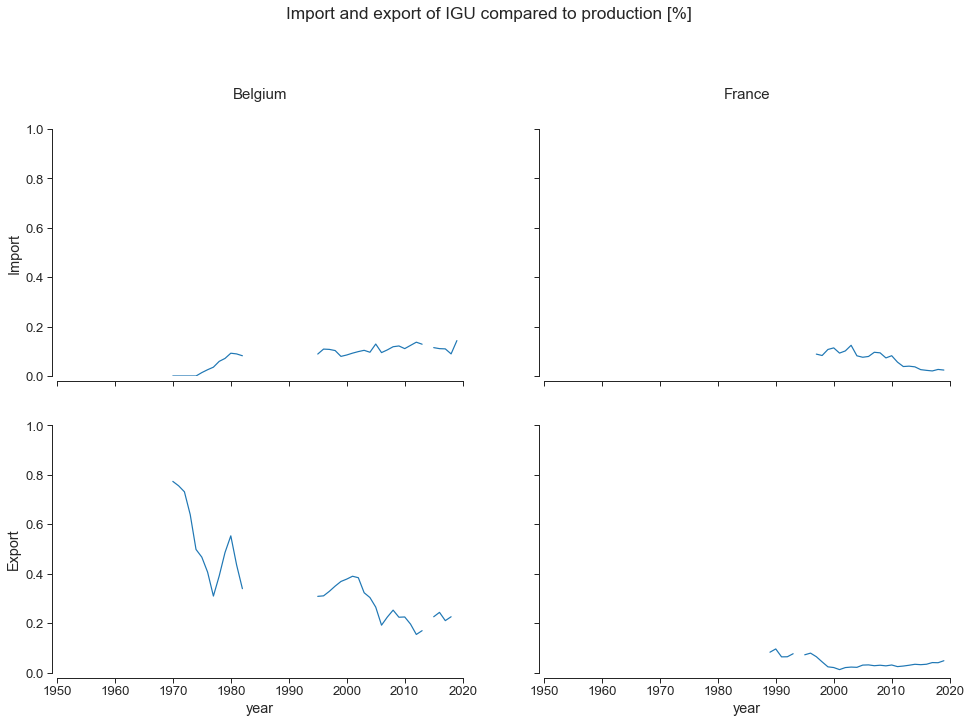

In [62]:
# Plot import and export ratios for FR and BE:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True)

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        (be_fr_igu[(f"{ratio} Ratio", '[kt]', country)].plot(ax=ax))

        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)


ax.set_ylim(0, 1)
ax.set_xlim(1950, 2020)

fig.suptitle("Import and export of IGU compared to production [%]",
             y=1.05)
sns.despine(offset=5)
plt.show()

In [63]:
# Interpolation for missing data:
cols = [x for x in be_fr_igu.columns if x[0] in ['Import Ratio',
                                                 'Export Ratio']]

be_fr_igu[cols] = (be_fr_igu[cols].interpolate(method='linear'))

In [64]:
be_fr_igu.loc[1990:2000, cols]

Info    Import Ratio                       Export Ratio                      
Unit       [10^6 m²]           [kt]           [10^6 m²]           [kt]       
Country      Belgium France Belgium France      Belgium France Belgium France
year                                                                         
1990            0.08    NaN    0.09    NaN         0.29   0.10    0.32   0.10
1991            0.09    NaN    0.09    NaN         0.28   0.06    0.32   0.06
1992            0.09    NaN    0.09    NaN         0.27   0.06    0.32   0.06
1993            0.09    NaN    0.09    NaN         0.27   0.08    0.31   0.08
1994            0.09    NaN    0.09    NaN         0.26   0.07    0.31   0.07
1995            0.09    NaN    0.09    NaN         0.25   0.07    0.31   0.07
1996            0.11    NaN    0.11    NaN         0.25   0.08    0.31   0.08
1997            0.11   0.09    0.11   0.09         0.27   0.06    0.33   0.06
1998            0.10   0.08    0.10   0.08         0.29   0.04    0.35   0.04
1999            0.08   0.11    0.08   0.11         0.30   0.02    0.37   0.02
2000            0.08   0.11    0.08   0.11         0.31   0.02    0.38   0.02

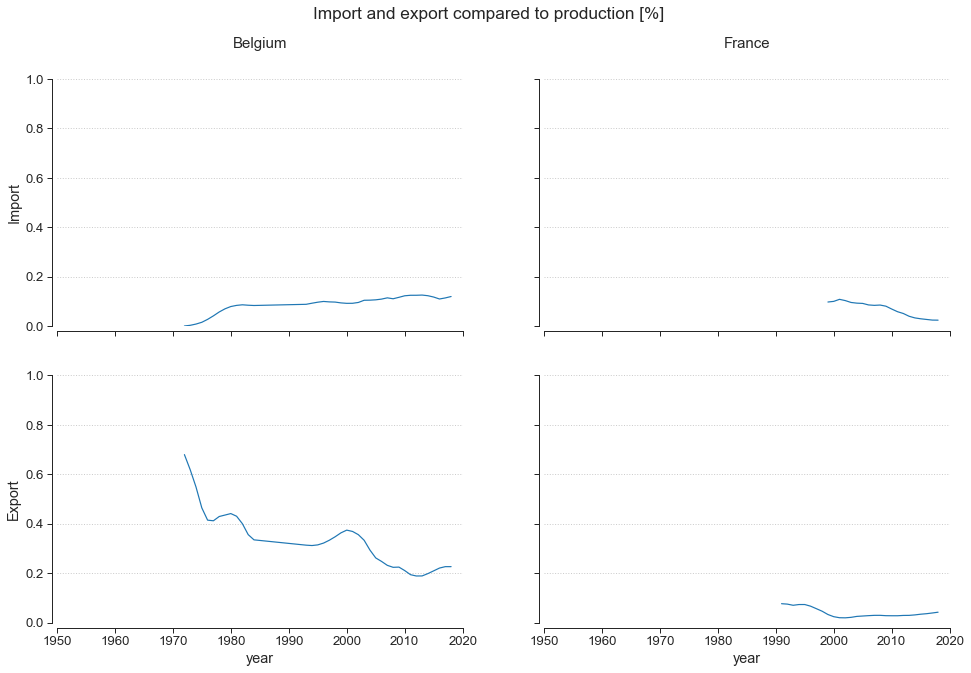

In [65]:
# Plot import and export ratios, w/ a moving average (5-y. window length):
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True)

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        (be_fr_igu[(f"{ratio} Ratio", '[kt]', country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax))

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("Import and export compared to production [%]")
sns.despine(offset=5)
plt.show()

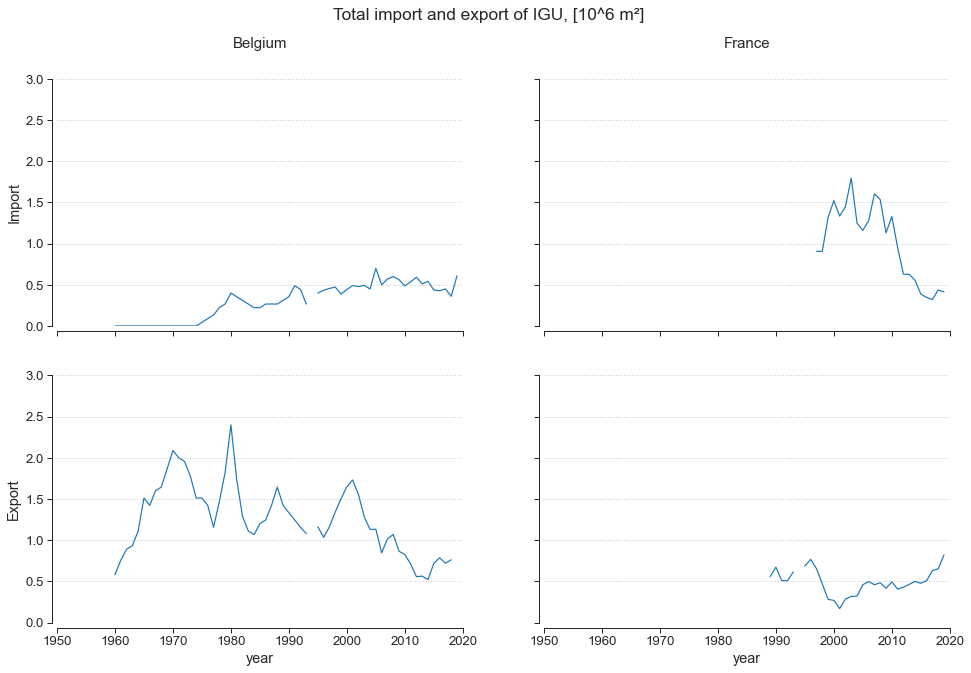

In [66]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True)

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        be_fr_igu[(f"{ratio}", '[10^6 m²]', country)].plot(ax=ax)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 3)

fig.suptitle('Total import and export of IGU, [10^6 m²]')
sns.despine(offset=5)
plt.show()

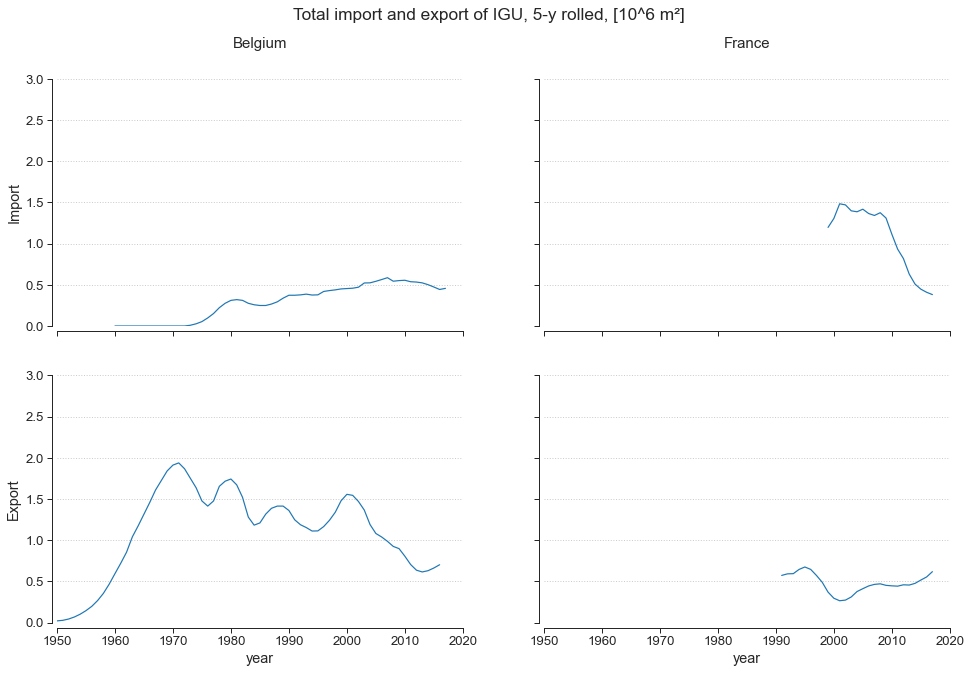

In [67]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True)

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        (be_fr_igu[(f"{ratio}", "[10^6 m²]", country)]
         .interpolate(method='linear', limit_area='inside')
         .rolling(5, center=True).mean()
         .plot(ax=ax))

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 3)

fig.suptitle('Total import and export of IGU, 5-y rolled, [10^6 m²]')
sns.despine(offset=5)
plt.show()

In [68]:
be_fr_igu = be_fr_igu.stack(level=[1, 2], dropna=False)

be_fr_igu['Consumption'] = (be_fr_igu['Production']
                            + be_fr_igu['Import']
                            - be_fr_igu['Export']
                            )

be_fr_igu = be_fr_igu.unstack(level=[1, 2])

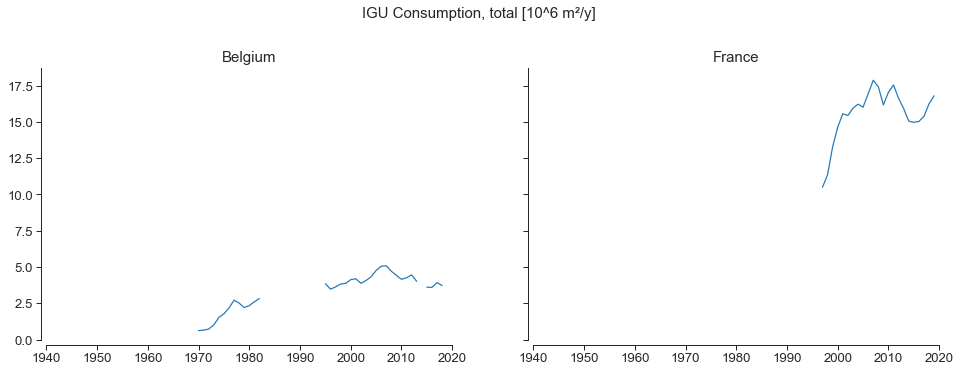

In [69]:
# Plot total consumption of IGU:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(be_fr_igu.index,
            be_fr_igu['Consumption', '[10^6 m²]'][country])
    ax.set_title(country)

ax.set_xlim(1940, 2020)
ax.set_ylim(ymin=0)

fig.suptitle('IGU Consumption, total [10^6 m²/y]', fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

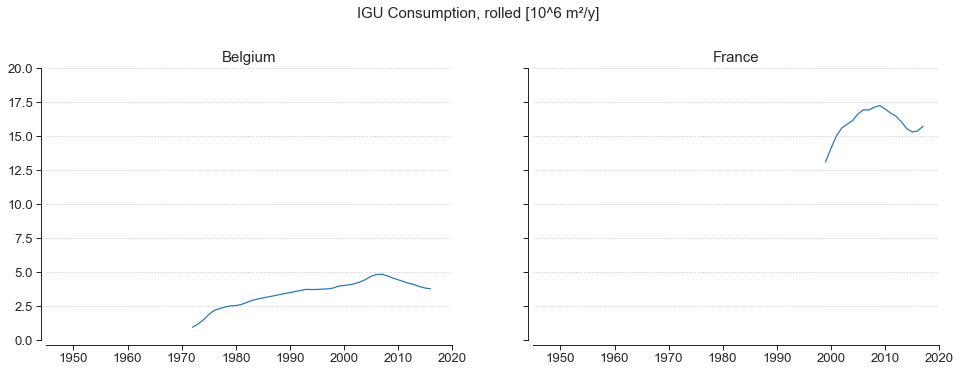

In [70]:
# Linear interpolation for IGU consumption
# and moving average with a 5-year window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr_igu.index,
            be_fr_igu['Consumption', '[10^6 m²]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 20)

fig.suptitle('IGU Consumption, rolled [10^6 m²/y]',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

In [71]:
# Estimating the IGU consumption per capita
for country in be_fr_igu['Consumption', '[10^6 m²]'].columns:
    be_fr_igu[('Consumption', '[m²/cap]', country)] = (
        be_fr_igu[('Consumption', '[10^6 m²]', country)]*1000
        / be_fr_pop[('Population [x1000]', country)])

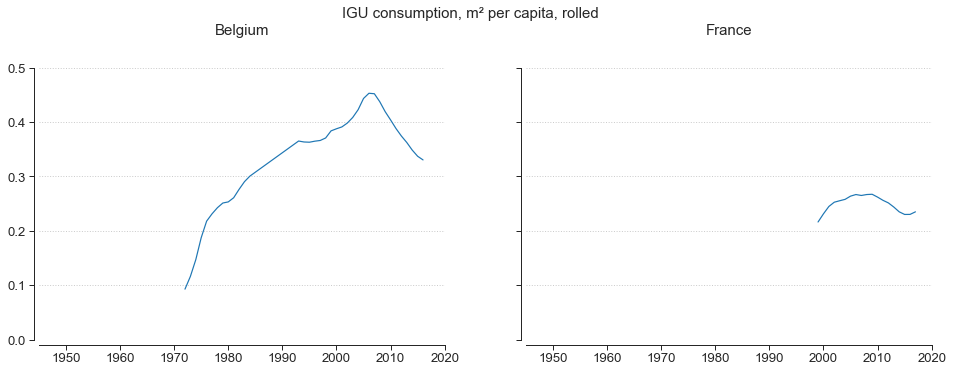

In [72]:
# Linear interpolation for IGU consumption per capita
# and moving average with a 5-y. window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr_igu.index,
            be_fr_igu['Consumption', '[m²/cap]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country, y=1.1)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 0.5)

fig.suptitle('IGU consumption, m² per capita, rolled',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

In [73]:
be_fr_igu = be_fr_igu.drop('[m²/cap]', axis=1, level=1)

## Summary

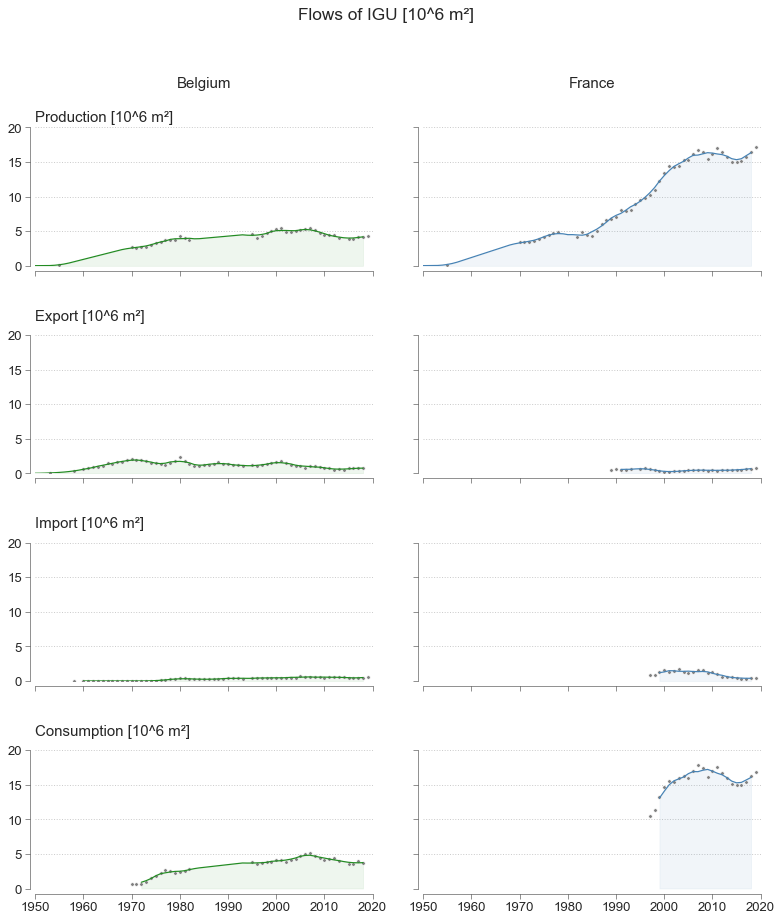

In [74]:
# Plot total import and export flows, moving average w/ a 5-y. window length:
toplot = ['Production', 'Export', 'Import', 'Consumption']
nrows = len(toplot)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(13, 14))

for row, data in enumerate(toplot):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'forestgreen'
            ax.set_title(f"{data} [10^6 m²]", loc='left', pad=15)
        else:
            color = 'steelblue'

        (be_fr_igu[(f"{data}", "[10^6 m²]", country)]
         .interpolate(method='linear')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color)
         )

        x = be_fr_igu.index
        y = (be_fr_igu[(f"{data}", "[10^6 m²]", country)]
             .interpolate(method='linear')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color=color, alpha=0.075)

        sns.scatterplot(data=be_fr_igu[f"{data}", "[10^6 m²]"][country],
                        marker='.', s=50, color='grey',
                        ax=ax)

        ax.get_legend().remove()

        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.set_ylabel(None)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 20)
plt.xticks(np.arange(1950, 2021, 10))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle("Flows of IGU [10^6 m²]", y=1)
sns.despine(offset=5)

plt.show()

Hypothesis for missing data: French production = French consumption

In [75]:
be_fr_igu = be_fr_igu.stack(level=[1, 2], dropna=False)

be_fr_igu["Estimated consumption"] = (
    be_fr_igu["Consumption"]
    .fillna(be_fr_igu["Production"])
)

be_fr_igu = be_fr_igu.unstack(level=[1, 2])

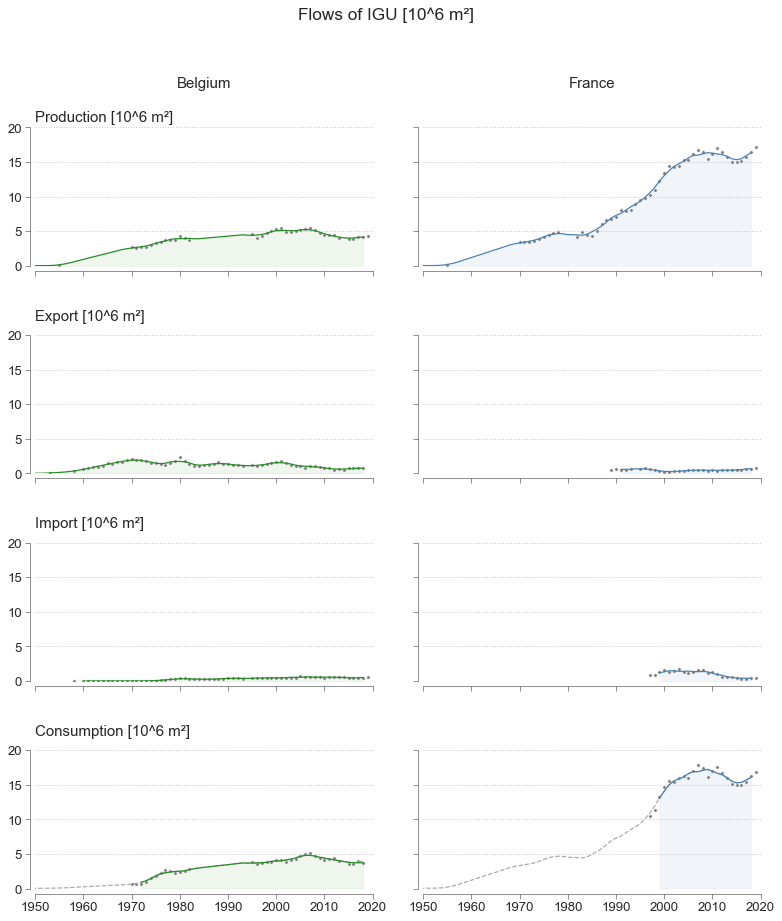

In [76]:
# Plot total import and export flows, moving average w/ a 5-y. window length:
toplot = ['Production', 'Export', 'Import', 'Consumption']
nrows = len(toplot)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(13, 14))

for row, data in enumerate(toplot):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'forestgreen'
            ax.set_title(f"{data} [10^6 m²]", loc='left', pad=15)
        else:
            color = 'steelblue'

        if row == 3:
            sns.lineplot(data=be_fr_igu[("Estimated consumption", "[10^6 m²]",
                                         country)]
                         .interpolate(method='linear')
                         .rolling(5, center=True).mean(),
                         linestyle='--', color='darkgrey', ax=ax)

        (be_fr_igu[(f"{data}", "[10^6 m²]", country)]
         .interpolate(method='linear')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color)
         )

        x = be_fr_igu.index
        y = (be_fr_igu[(f"{data}", "[10^6 m²]", country)]
             .interpolate(method='linear')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color=color, alpha=0.075)

        sns.scatterplot(data=be_fr_igu[f"{data}", "[10^6 m²]"][country],
                        marker='.', s=50, color='grey',
                        ax=ax)

        ax.get_legend().remove()

        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.set_ylabel(None)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 20)
plt.xticks(np.arange(1950, 2021, 10))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle("Flows of IGU [10^6 m²]", y=1)
sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixC_BEFR_IGUFlows.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixC_BEFR_IGUFlows.pdf'),
                bbox_inches='tight')

plt.show()

# The Environmental Footprint Relating to the Production (and consumption) of IGU in the EU

## Raw Material Use for IGU Production

In [77]:
# Absolute use of raw materials for IGU production:
for material in materials:
    eu_igu[(f"{material}, IGU production", '[kt]')] = (
        eu_igu[('Production', '[kt]')]
        * (mat_intensity[(f"{material}, kg/kg")]
           .interpolate(method='pchip', limit_direction='forward'))
    )

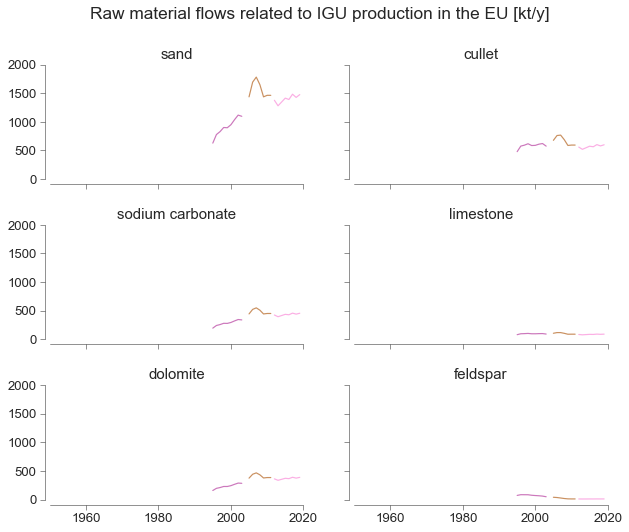

In [78]:
# Plot raw material flows for IGU production in the EU:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    sns.lineplot(data=eu_igu[f"{material}, IGU production"].reset_index(),
                 x='year', y='[kt]',
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(material)
    ax.set_ylabel(None)
    style_ax(ax)
    ax.get_legend().remove()

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 2000)

fig.suptitle("Raw material flows related to IGU production in the EU [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

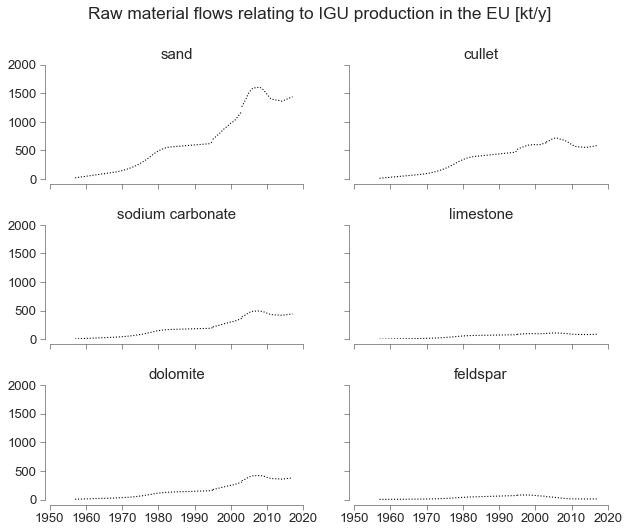

In [79]:
# Plot raw material flows for EU IGU production
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    for a, b in eu_list:
        ax.plot(eu_igu.interpolate()
                .rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{material}, IGU production", '[kt]')],
                linewidth=1.1, c='black', linestyle=':'
                )
        ax.set_title(material)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 2000)

fig.suptitle("Raw material flows relating to IGU production in the EU [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [80]:
# Estimate total use of raw materials (sum per material):
eu_igu[('Total raw materials, IGU production', '[Mt]')] = 0

for material in materials:
    eu_igu[('Total raw materials, IGU production', '[Mt]')] = (
        eu_igu[(f"{material}, IGU production", '[kt]')]/1000
        + eu_igu[('Total raw materials, IGU production', '[Mt]')]
    )

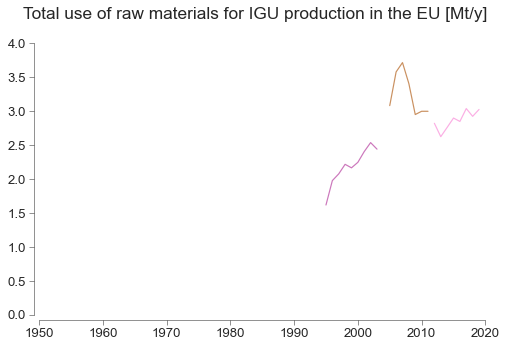

In [81]:
# Plot total material use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_igu['Total raw materials, IGU production'].reset_index(),
             x='year', y='[Mt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0,4)
ax.set_ylabel(None)
style_ax(ax)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for IGU production in the EU [Mt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

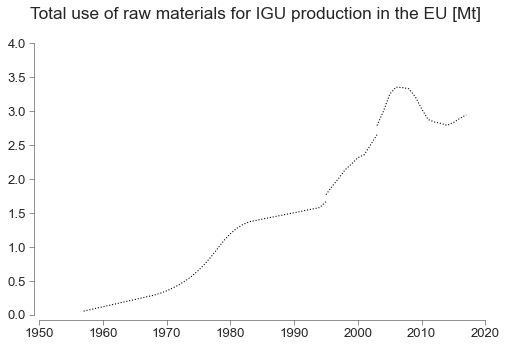

In [82]:
# Plot total material use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in eu_list:
    ax.plot(eu_igu.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total raw materials, IGU production', '[Mt]')],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 4)
style_ax(ax)

fig.suptitle("Total use of raw materials for IGU production in the EU [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Energy use for the production of IGU

In [83]:
# Absolute use of energy for IGU production:
for energy in energies:
    eu_igu[(f"{energy}, IGU production", '[PJ]')] = (
        eu_igu[('Production', '[kt]')]
        * (energy_intensity[f"{energy}, GJ/t"]
           .interpolate(method='pchip', limit_direction='forward'))/1000
    )

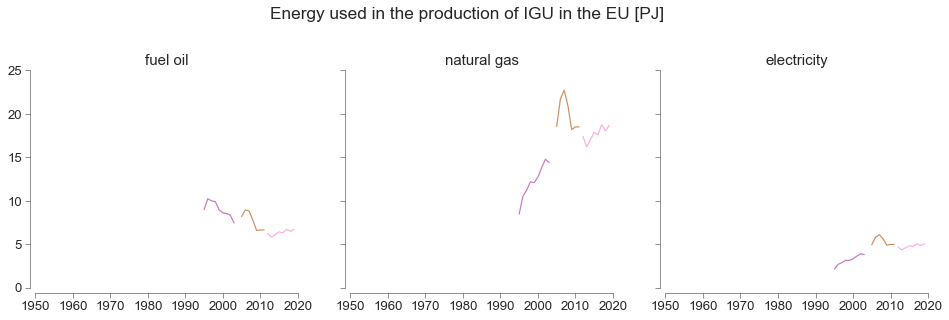

In [84]:
# Plot energy used for IGU production in EU:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    sns.lineplot(data=eu_igu[f"{energy}, IGU production"].reset_index(),
                 x='year', y="[PJ]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(energy)
    ax.get_legend().remove()
    ax.set_ylabel(None)
    style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 25)

fig.suptitle("Energy used in the production of IGU in the EU [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

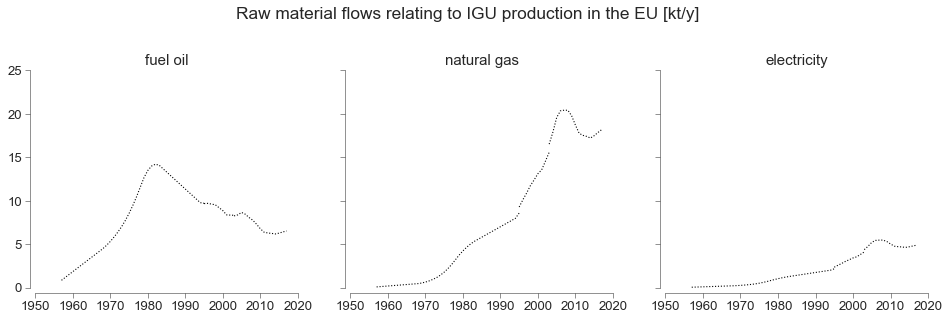

In [85]:
# Plot energy flows for IGU production, 5-y rolled:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for a, b in eu_list:
        ax.plot(eu_igu.interpolate()
                .rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{energy}, IGU production", '[PJ]')],
                linewidth=1.1, c='black', linestyle=':'
                )
        ax.set_title(energy)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 25)

fig.suptitle("Raw material flows relating to IGU production in the EU [kt/y]", 
             y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [86]:
eu_igu[('Total energy, IGU production', '[PJ]')] = 0

for energy in energies:
    eu_igu[('Total energy, IGU production', '[PJ]')] = (
        eu_igu[(f"{energy}, IGU production", '[PJ]')]
        + eu_igu[('Total energy, IGU production', '[PJ]')]
    )

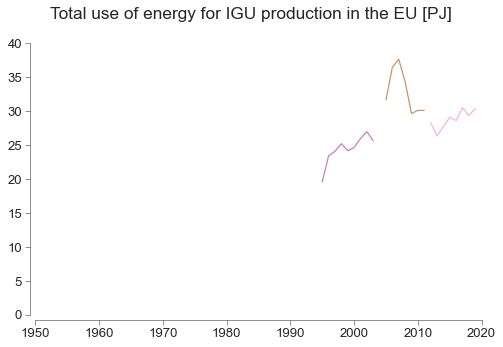

In [87]:
# Plot total energy use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_igu['Total energy, IGU production'].reset_index(),
             x='year', y='[PJ]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 40)
ax.get_legend().remove()
ax.set_ylabel(None)
style_ax(ax)

fig.suptitle("Total use of energy for IGU production in the EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

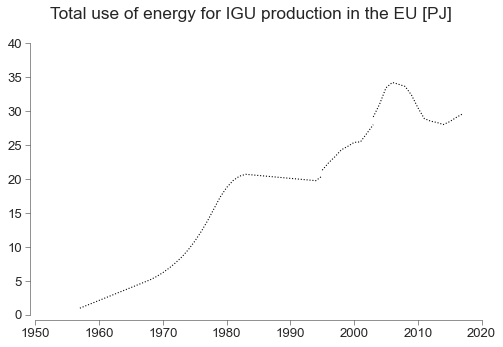

In [88]:
# Plot total energy use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in eu_list:
    ax.plot(eu_igu.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total energy, IGU production', '[PJ]')],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)
style_ax(ax)

fig.suptitle("Total use of energy for IGU production in the EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Absolute CO2 emissions relating to the production of IGU, EU

In [89]:
# Estimating the co2 emission related to IGU production
eu_igu[('co2, IGU production', '[kt]')] = (
    eu_igu[('Production', '[kt]')]
    * co2_intensity['CO2 interpolated [kg/t]'] / 1000
)

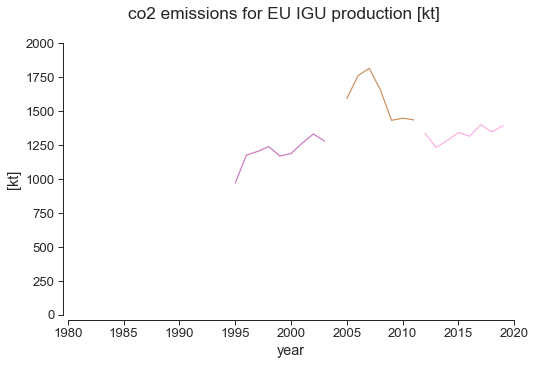

In [90]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_igu['co2, IGU production'].reset_index(),
             x='year', y='[kt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 2000)
ax.get_legend().remove()

fig.suptitle("co2 emissions for EU IGU production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

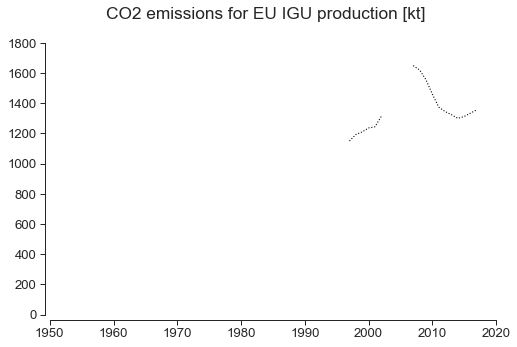

In [91]:
# Plot total energy use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in eu_list:
    ax.plot(eu_igu.rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('co2, IGU production', '[kt]')],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1800)

fig.suptitle("CO2 emissions for EU IGU production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

## Summary

In [92]:
# Number of countries for trend curves:
c = [(6, 12), (10, 15), (27, 28)]

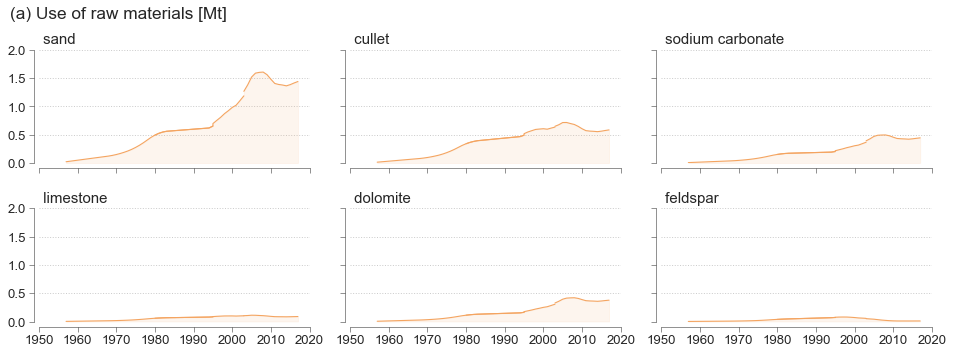

In [93]:
# Plot the absolute use of raw materials for IGU prod in the EU:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    for a, b in c:
        ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{material}, IGU production", '[kt]'],
                linewidth=1.1, c='sandybrown', linestyle='-')

    x = (eu_igu.reset_index()['year'])
    y = (eu_igu[(f"{material}, IGU production", '[kt]')].interpolate()
         .rolling(5, center=True).mean())

    ax.fill_between(x, y, color="sandybrown", alpha=0.1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f" {material}", loc='left')
    style_ax(ax)

ax.set_ylim(0, 2000)
ax.set_xlim(1950, 2020)
plt.yticks(np.arange(0, 2001, 500))
plt.xticks(np.arange(1950, 2021, 10))

# Divide by 1000 the y-axis, results in Mt:
ax.yaxis.set_major_formatter(y_1000)

fig.suptitle("(a) Use of raw materials [Mt]", x=0.1, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of raw materials.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of raw materials.pdf'),
                bbox_inches='tight')

plt.show()

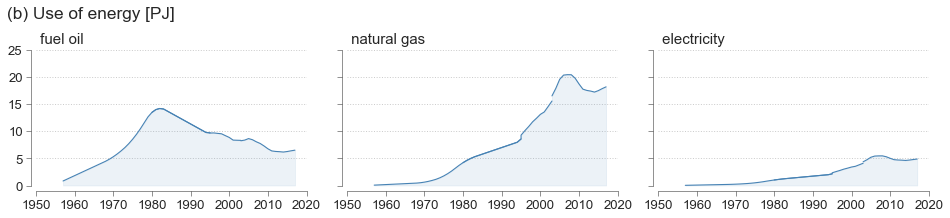

In [94]:
# Plot the absolute use of energy in the EU for architectural glass prod:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for a, b in c:
        ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{energy}, IGU production", '[PJ]')],
                linewidth=1.1, c='steelblue', linestyle='-')

    x = (eu_igu.reset_index()['year'])
    y = (eu_igu[(f"{energy}, IGU production", '[PJ]')].interpolate()
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="steelblue", alpha=0.10)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f" {energy}", loc='left')
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 25)
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(b) Use of energy [PJ]", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of energy.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of energy.pdf'),
                bbox_inches='tight')

plt.show()

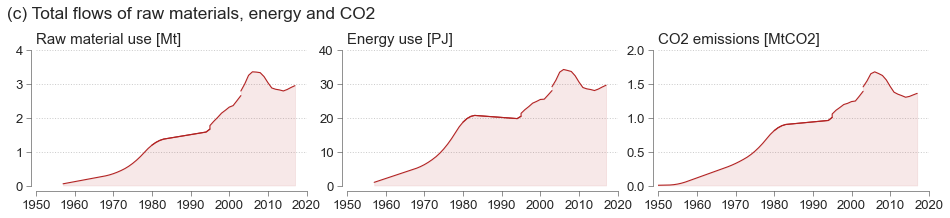

In [95]:
# Plot total energy and material use, and total CO2 emissions for IGU prod:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Total use of raw materials:
ax = axes[0]
for a, b in c:
    ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total raw materials, IGU production', '[Mt]')],
            linewidth=1.1, c='firebrick', linestyle='-')

x = (eu_igu.reset_index()['year'])
y = (eu_igu[('Total raw materials, IGU production', '[Mt]')].interpolate()
     .rolling(5, center=True).mean())
ax.fill_between(x, y, color="firebrick", alpha=0.1)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Raw material use [Mt]", loc='left')
style_ax(ax)
ax.set_ylim(0, 4)
ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

# Total use of energy:
ax = axes[1]
for a, b in c:
    ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('Total energy, IGU production', '[PJ]')],
            linewidth=1.1, c='firebrick', linestyle='-')

x = (eu_igu.reset_index()['year'])
y = (eu_igu[('Total energy, IGU production', '[PJ]')].interpolate()
     .rolling(5, center=True).mean())
ax.fill_between(x, y, color="firebrick", alpha=0.1)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Energy use [PJ]", loc='left')
style_ax(ax)
ax.set_ylim(0, 40)

# Total emissions of CO2:
ax = axes[2]
for a, b in c:
    ax.plot(eu_igu.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            [('co2, IGU production', '[kt]')],
            linewidth=1.1, c='firebrick', linestyle='-')

x = (eu_igu.reset_index()['year'])
y = (eu_igu[('co2, IGU production', '[kt]')].interpolate()
     .rolling(5, center=True).mean())
ax.fill_between(x, y, color="firebrick", alpha=0.1)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

# Divide by 1000 the y-axis, results in Mt
ax.yaxis.set_major_formatter(y_1000)

ax.set_title("CO2 emissions [MtCO2]", loc='left')
style_ax(ax)
ax.set_ylim(0, 2000)

fig.suptitle("(c) Total flows of raw materials, energy and CO2",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)

sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig5_EU_Total flows.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig5_EU_Total flows.pdf'),
                bbox_inches='tight')

plt.show()

# The Environmental Footprint of IGU used in BE and FR

## Raw Material Use for IGU Production

In [96]:
# Absolute use of raw materials for IGU consumption:
for mat in materials:
    for country in be_fr_igu[('Estimated consumption', '[kt]')].columns:
        be_fr_igu[(f"{mat}, IGU consum", '[kt]', country)] = (
            be_fr_igu[('Estimated consumption', '[kt]', country)]
            * (mat_intensity[(f"{mat}, kg/kg")]
               .interpolate(method='pchip', limit_direction='forward'))
        )

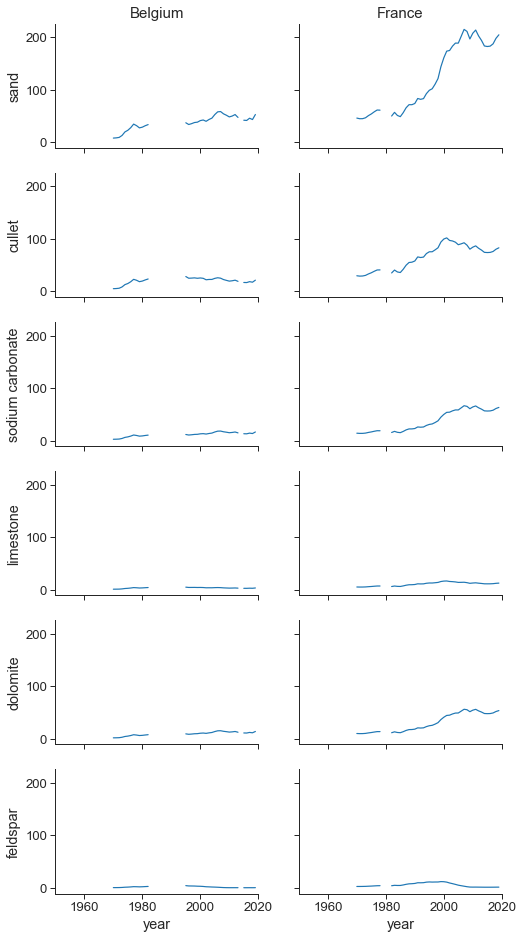

In [97]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 16))

for row, mat in enumerate(materials):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(mat)
        be_fr_igu[(f"{mat}, IGU consum", '[kt]', country)].plot(ax=ax)

ax.set_xlim(1950, 2020)

sns.despine()
plt.show()

In [98]:
for country in countries:
    be_fr_igu[('Total raw material use, IGU consum', '[kt]', country)] = 0

for mat in materials:
    be_fr_igu['Total raw material use, IGU consum', '[kt]'] = (
        be_fr_igu[f"{mat}, IGU consum", '[kt]']
        + be_fr_igu[('Total raw material use, IGU consum', '[kt]')]
    )

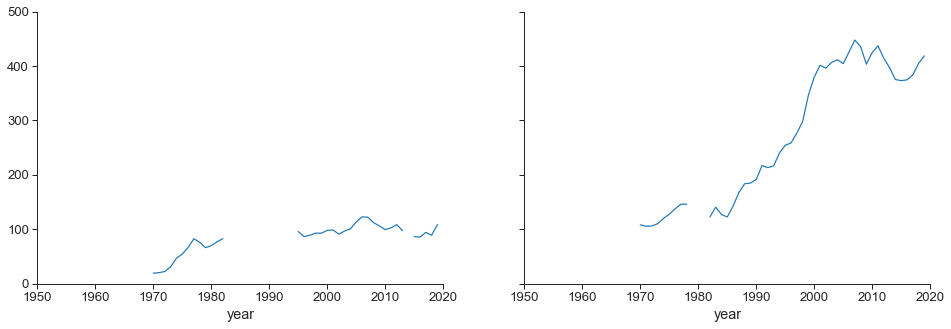

In [99]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (be_fr_igu[('Total raw material use, IGU consum', '[kt]', country)]
     .plot(ax=ax))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 500)
sns.despine()
plt.show()

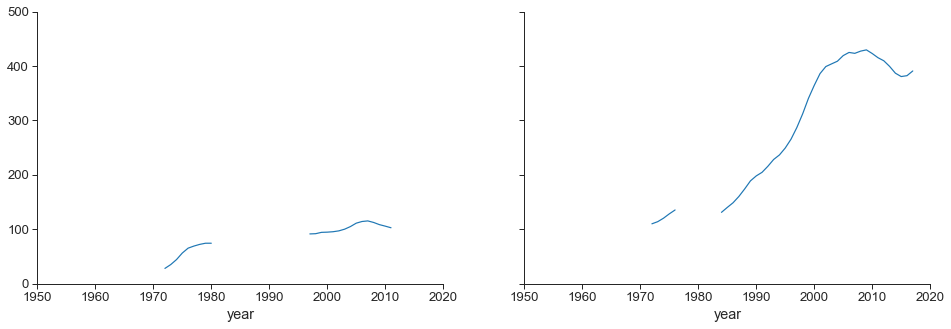

In [100]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (be_fr_igu[('Total raw material use, IGU consum', '[kt]', country)]
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 500)
sns.despine()
plt.show()

## Energy use for IGU Production

In [101]:
# Absolute use of energy for IGU production:
for energy in energies:
    for country in countries:
        be_fr_igu[(f"{energy}, IGU consum", '[TJ]', country)] = (
            be_fr_igu[('Estimated consumption', '[kt]', country)]
            * (energy_intensity[(f"{energy}, GJ/t")]
               .interpolate(method='pchip', limit_direction='forward'))
        )

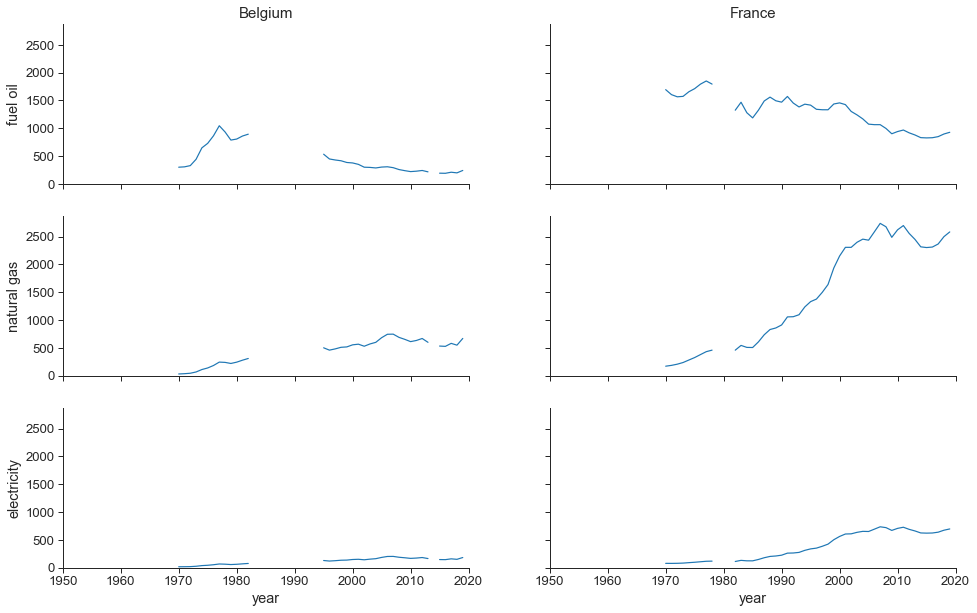

In [102]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        be_fr_igu[(f"{energy}, IGU consum", '[TJ]', country)].plot(ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(ymin=0)

sns.despine()
plt.show()

In [103]:
# Total energy use for IGU production (sum of energy sources):
for country in countries:
    be_fr_igu[('Total energy use, IGU consum', '[TJ]', country)] = 0

for energy in energies:
    be_fr_igu[('Total energy use, IGU consum', '[TJ]')] = (
        be_fr_igu[f"{energy}, IGU consum", '[TJ]']
        + be_fr_igu[('Total energy use, IGU consum', '[TJ]')]
    )

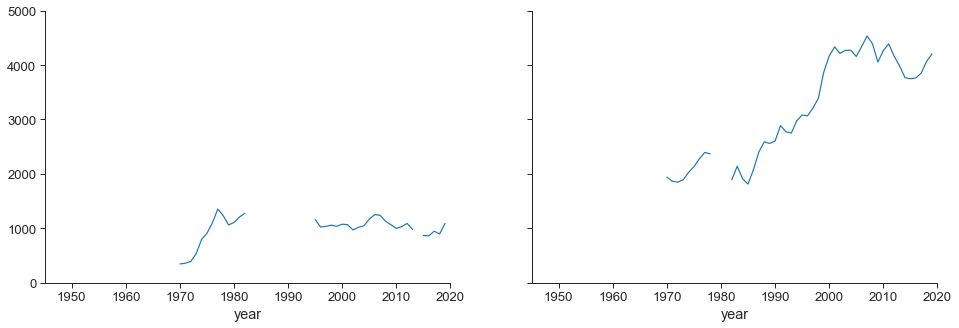

In [104]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (be_fr_igu[('Total energy use, IGU consum', '[TJ]', country)]
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 5000)
sns.despine()
plt.show()

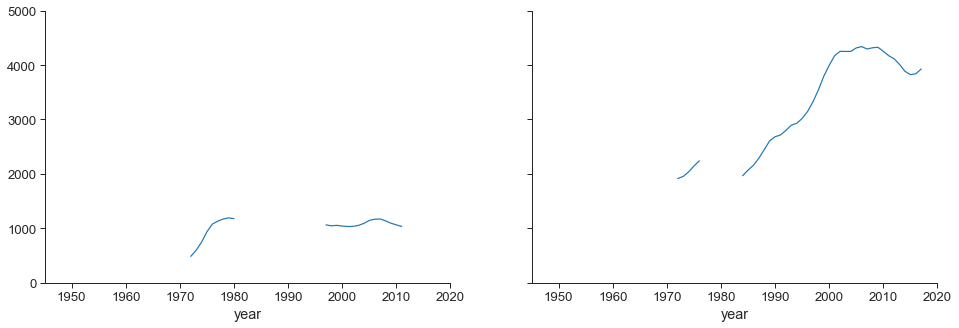

In [105]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (be_fr_igu[('Total energy use, IGU consum', '[TJ]', country)]
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 5000)
sns.despine()
plt.show()

## CO2 emissions Relating to IGU Consumption in France and Belgium

In [106]:
# Estimating the CO2 emission related to IGU consumption
for country in be_fr_igu[('Estimated consumption', '[kt]')].columns:
    be_fr_igu[('CO2, IGU consum', '[ktCO2]', country)] = (
        be_fr_igu[('Estimated consumption', '[kt]', country)]
        * co2_intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [107]:
# Estimating the CO2 emission related to IGU production
for country in be_fr_igu[('Production', '[kt]')].columns:
    be_fr_igu[('CO2, IGU production', '[ktCO2]', country)] = (
        be_fr_igu[('Production', '[kt]', country)]
        * co2_intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [108]:
co2_igu = ['production', 'consum']

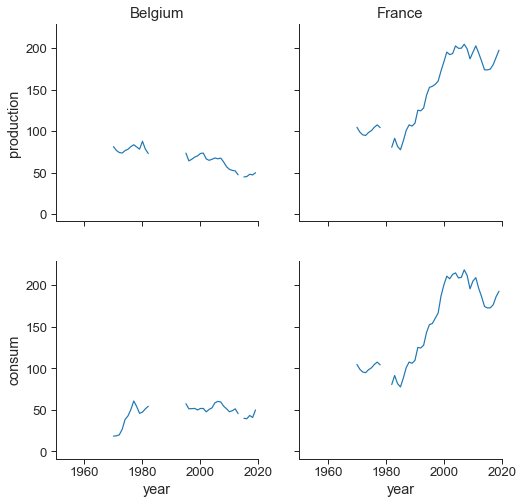

In [109]:
nrows = len(co2_igu)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 8))

for row, co2 in enumerate(co2_igu):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(co2)
        be_fr_igu[(f"CO2, IGU {co2}", '[ktCO2]', country)].plot(ax=ax)

ax.set_xlim(1950, 2020)

sns.despine()
plt.show()

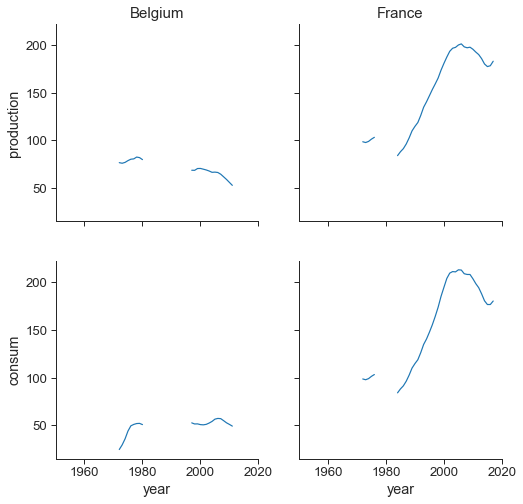

In [110]:
nrows = len(co2_igu)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 8))

for row, co2 in enumerate(co2_igu):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(co2)
        (be_fr_igu[(f"CO2, IGU {co2}", '[ktCO2]', country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax))

ax.set_xlim(1950, 2020)

sns.despine()
plt.show()

## Summary

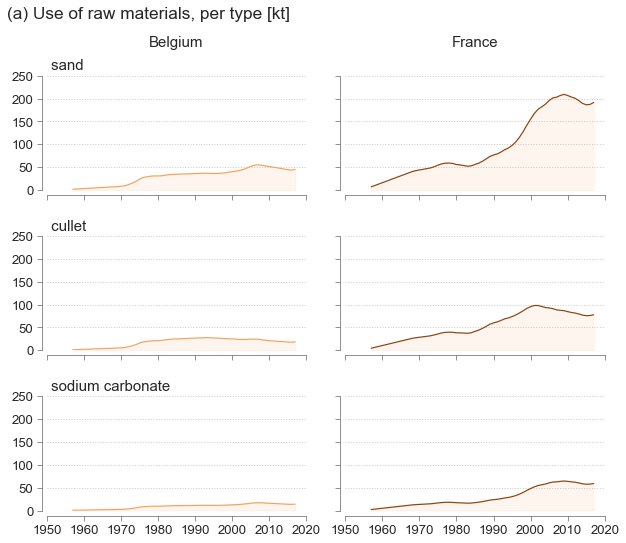

In [111]:
# Raw materials, per type:
mat_reduced = ['sand', 'cullet', 'sodium carbonate']

nrows = len(mat_reduced)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for row, material in enumerate(mat_reduced):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if country == 'Belgium':
            color = 'sandybrown'
            ax.set_title(f" {material}", loc='left')
        else:
            color = 'saddlebrown'

        (be_fr_igu[(f"{material}, IGU consum", '[kt]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color))

        x = be_fr_igu.index
        y = (be_fr_igu[(f"{material}, IGU consum", '[kt]', country)]
             .interpolate(method="linear", limit_area='inside')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color="sandybrown", alpha=0.1)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        if row == 0:
            ax.set_title(country, y=1.2)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 250)
plt.xticks(np.arange(1950, 2021, 10))
plt.yticks(np.arange(0, 251, 50))

fig.suptitle("(a) Use of raw materials, per type [kt]",
             x=0.07, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig6_BEFR_Use of raw materials.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig6_BEFR_Use of raw materials.pdf'),
                bbox_inches='tight')

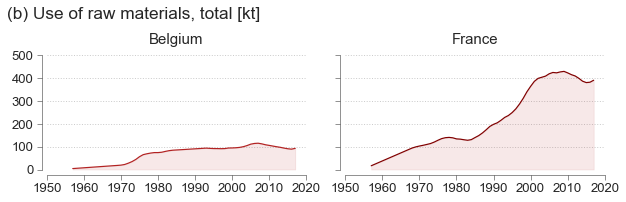

In [112]:
# Raw materials, total:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 2.1))

for col, country in enumerate(countries):
    ax = axes[col]
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'maroon'

    (be_fr_igu[("Total raw material use, IGU consum", '[kt]', country)]
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c=color))

    x = be_fr_igu.index
    y = (be_fr_igu[("Total raw material use, IGU consum", '[kt]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="firebrick", alpha=0.1)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)
    ax.set_title(country, y=1.05)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

ax.set_ylim(0, 500)
plt.yticks(np.arange(0, 501, 100))

fig.suptitle("(b) Use of raw materials, total [kt]",
             x=0.07, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig6_BEFR_Total raw materials.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig6_BEFR_Total raw materials.pdf'),
                bbox_inches='tight')

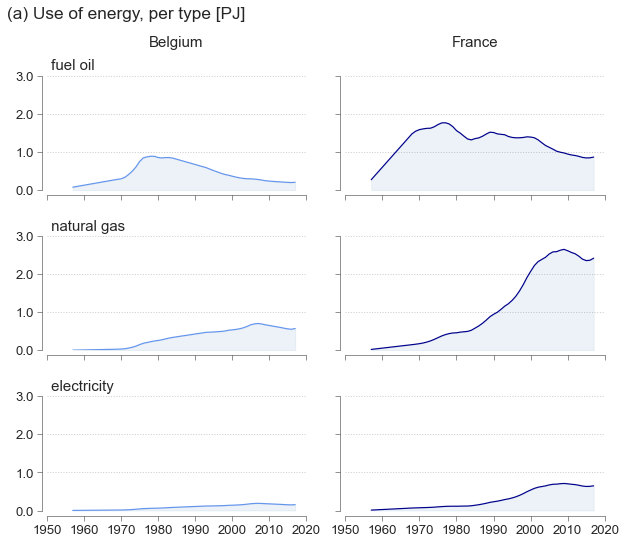

In [113]:
# Energy use, per type:
nrows = len(energies)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if country == 'Belgium':
            color = 'cornflowerblue'
            ax.set_title(f" {energy}", loc='left')
        else:
            color = 'darkblue'

        (be_fr_igu[(f"{energy}, IGU consum", '[TJ]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color)
         )

        x = be_fr_igu.index
        y = (be_fr_igu[(f"{energy}, IGU consum", '[TJ]', country)]
             .interpolate(method="linear", limit_area='inside')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color="steelblue", alpha=0.1)

        # Divide by 1000 the y-axis, results in PJ
        ax.yaxis.set_major_formatter(y_1000)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        if row == 0:
            ax.set_title(country, y=1.2)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 3000)

plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(a) Use of energy, per type [PJ]",
             x=0.07, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_Use of energy.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_Use of energy.pdf'),
                bbox_inches='tight')

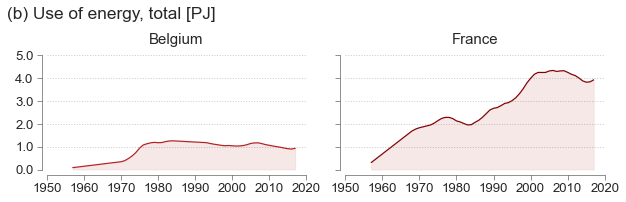

In [114]:
# Energy use, total:
fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 2.1))

for col, country in enumerate(countries):
    ax = axes[col]
    ax = axes[col]
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'maroon'

    (be_fr_igu[('Total energy use, IGU consum', '[TJ]', country)]
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c=color))

    x = be_fr_igu.index
    y = (be_fr_igu[('Total energy use, IGU consum', '[TJ]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="firebrick", alpha=0.1)

    # Divide by 1000 the y-axis, results in PJ
    ax.yaxis.set_major_formatter(y_1000)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)
    ax.set_title(country, y=1.05)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))

ax.set_ylim(0, 5000)
plt.yticks(np.arange(0, 5001, 1000))

fig.suptitle("(b) Use of energy, total [PJ]",
             x=0.07, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_Total enrgy.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_Total enrgy.pdf'),
                bbox_inches='tight')

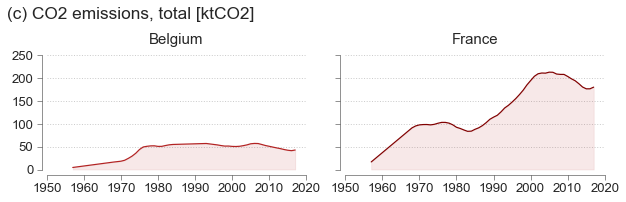

In [115]:
# CO2 emissions, total:
fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 2.1))

for col, country in enumerate(countries):
    ax = axes[col]
    ax = axes[col]
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'maroon'

    (be_fr_igu[('CO2, IGU consum', '[ktCO2]', country)]
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c=color))

    x = be_fr_igu.index
    y = (be_fr_igu[('CO2, IGU consum', '[ktCO2]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="firebrick", alpha=0.1)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)
    ax.set_title(country, y=1.05)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 250)
plt.yticks(np.arange(0, 251, 50))

fig.suptitle("(c) CO2 emissions, total [ktCO2]",
             x=0.07, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_TotalCO2.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig7_BEFR_TotalCO2.pdf'),
                bbox_inches='tight')

# Relative v. Absolute Decoupling: A Base 100 Analysis

## IGU Production, France and Belgium, 1960-1980

In [116]:
a = 1970
b = 1990

In [117]:
# Base 100 = 1960
igu_prod_diff = (100 * be_fr_igu[('Estimated consumption', '[kt]')]
                 .interpolate(method='linear').rolling(5, center=True).mean()
                 / be_fr_igu[('Estimated consumption', '[kt]')]
                 .interpolate(method='linear').rolling(5, center=True).mean()
                 .loc[a]
                 )

co2intensity_diff = 100 * co2_intensity / co2_intensity.loc[a]

co2_abs_diff = (100 * be_fr_igu[('CO2, IGU consum', '[ktCO2]')]
                .interpolate(method='linear').rolling(5, center=True).mean()
                / be_fr_igu[('CO2, IGU consum', '[ktCO2]')]
                .interpolate(method='linear').rolling(5, center=True).mean()
                .loc[a]
                )

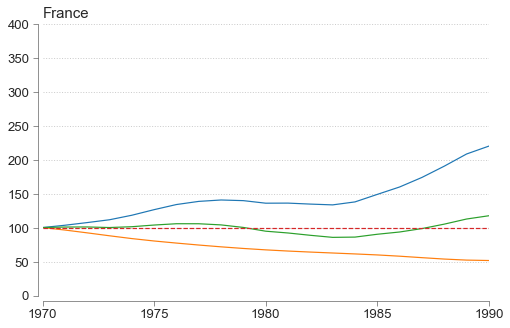

In [118]:
# Plot production, carbon intensity and CO2 absolute emissions for France:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=igu_prod_diff,
             x=igu_prod_diff.index,
             y='France',
             ax=ax)

ax.plot(co2intensity_diff.index,
        co2intensity_diff['CO2 interpolated [kg/t]'])

ax.plot(co2_abs_diff.index,
        co2_abs_diff['France'])

ax.plot([a, b], [100, 100], '--')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_ylim(0, 400)
#plt.yticks(np.arange(0, 201, 50))
ax.set_xlim(a, b)
plt.xticks(np.arange(a, b+1, 5))

ax.set_title("France", loc='left')
ax.set_ylabel(None)
style_ax(ax)

sns.despine(offset=5)
plt.show()

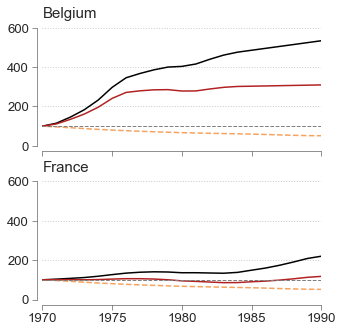

In [119]:
# Plot production, carbon intensity, CO2 absolute emissions for FR and BE:
fig, axes = plt.subplots(nrows=2, ncols=1,
                         sharex=True, sharey=True,
                         figsize=(5, 5))


for col, country in enumerate(countries):
    ax = axes[col]

    sns.lineplot(data=igu_prod_diff,
                 x=igu_prod_diff.index,
                 y=f'{country}',
                 ax=ax, color='black', linewidth=1.5)

    ax.plot(co2intensity_diff.index,
            co2intensity_diff['CO2 interpolated [kg/t]'],
            color='sandybrown', linestyle='--', linewidth=1.5)

    ax.plot(co2_abs_diff.index,
            co2_abs_diff[f'{country}'],
            color='firebrick', linewidth=1.5)

    ax.set_xlim(a, b)
    plt.xticks(np.arange(a, b+1, 5))
    ax.set_ylabel(None)

    ax.plot([a, b], [100, 100], '--', c='grey', linewidth=1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f"{country}", loc='left', pad=10)
    style_ax(ax)

ax.set_ylim(0, 600)
plt.yticks(np.arange(0, 601, 200))

fig.subplots_adjust(hspace=0.3)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'BE_FR_IGU_Base100_60-80.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'BE_FR_IGU_Base100_60-80.pdf'),
                bbox_inches='tight')

In [120]:
for country in countries:
    print(f"IGU Prod in {country}:\n",
          '%.2f'%igu_prod_diff[f'{country}'].loc[b])
    print(f"CO2 absolute emissions in {country}:\n",
          '%.2f'%co2_abs_diff[f'{country}'].loc[b])
    print("CO2 intensity:\n",
          '%.2f'%co2intensity_diff['CO2 interpolated [kg/t]'].loc[b])

IGU Prod in Belgium:
 533.82
CO2 absolute emissions in Belgium:
 309.55
CO2 intensity:
 51.49
IGU Prod in France:
 219.87
CO2 absolute emissions in France:
 117.38
CO2 intensity:
 51.49


## IGU Production, France and Belgium, 1985-2005

In [121]:
c = 1990
d = 2010

In [122]:
# Base 100 = 1985
igu_prod_diff = (100 * be_fr_igu[('Estimated consumption', '[kt]')]
                 .interpolate(method='linear').rolling(5, center=True).mean()
                 / be_fr_igu[('Estimated consumption', '[kt]')]
                 .interpolate(method='linear').rolling(5, center=True).mean()
                 .loc[c]
                 )

co2intensity_diff = 100 * co2_intensity / co2_intensity.loc[c]

co2_abs_diff = (100 * be_fr_igu[('CO2, IGU consum', '[ktCO2]')]
                .interpolate(method='linear').rolling(5, center=True).mean()
                / be_fr_igu[('CO2, IGU consum', '[ktCO2]')]
                .interpolate(method='linear').rolling(5, center=True).mean()
                .loc[c]
                )

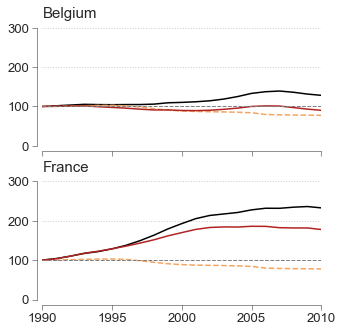

In [123]:
# Plot production, carbon intensity, CO2 absolute emissions for FR and BE:
fig, axes = plt.subplots(nrows=2, ncols=1,
                         sharex=True, sharey=True,
                         figsize=(5, 5))


for col, country in enumerate(countries):
    ax = axes[col]

    sns.lineplot(data=igu_prod_diff,
                 x=igu_prod_diff.index,
                 y=f'{country}',
                 ax=ax, color='black', linewidth=1.5)

    ax.plot(co2intensity_diff.index,
            co2intensity_diff['CO2 interpolated [kg/t]'],
            color='sandybrown', linestyle='--', linewidth=1.5)

    ax.plot(co2_abs_diff.index,
            co2_abs_diff[f'{country}'],
            color='firebrick', linewidth=1.5)

    ax.set_xlim(c, d)
    plt.xticks(np.arange(c, d+1, 5))
    ax.set_ylabel(None)

    ax.plot([c, d], [100, 100], '--', c='grey', linewidth=1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f"{country}", loc='left', pad=10)
    style_ax(ax)

ax.set_ylim(0, 300)
plt.yticks(np.arange(0, 301, 100))

fig.subplots_adjust(hspace=0.3)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'BE_FR_IGU_Base100_60-80.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'BE_FR_IGU_Base100_60-80.pdf'),
                bbox_inches='tight')

# Dynamic Stock Modelling

See: Pauliuk, Stefan, and Niko Heeren, 2019, "ODYM—An open software framework for studying dynamic material systems: Principles, implementation, and data structures", Journal of Industrial Ecology, 24:3, 446-458.

ODYM is an open source community tool released under the MIT license and hosted on the following GitHub repository: https://github.com/indecol/odym

## Define System

In [124]:
# Create dictionary of model classifications:
ModelClassification = {}

# Retrospective MFA from 1945 to 2020:
MyYears = list(np.arange(1945, 2021))

In [125]:
# Classification for time labelled 'Time' must always be present,
# with Items containing a list of odered integers representing years, months,
# or other discrete time intervals:
ModelClassification['Time'] = msc.Classification(Name='Time',
                                                 Dimension='Time',
                                                 ID=1, Items=MyYears)

In [126]:
# Classification for cohort is used to track age-cohorts in the stock:
ModelClassification['Cohort'] = msc.Classification(Name='Age-cohort',
                                                   Dimension='Time',
                                                   ID=1, Items=MyYears)

In [127]:
# Classification for elements labelled 'Element':
ModelClassification['Element'] = msc.Classification(Name='Elements',
                                                    Dimension='Element',
                                                    ID=2, Items=['IGU'])

In [128]:
# Classification for regions including Belgium, France and the EU:
MyRegions = ['BE', 'FR', 'EU']

ModelClassification['Region'] = msc.Classification(Name='Regions',
                                                   Dimension='Region',
                                                   ID=3, Items=MyRegions)

In [129]:
# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End = int(max(ModelClassification['Time'].Items))
Model_Duration = Model_Time_End - Model_Time_Start

In [130]:
Model_Duration

75

In [131]:
# The indext table lists all aspects needed
# and assigns a classification and index letter to each aspect:
IndexTable = (
    pd.DataFrame(
        {'Aspect': ['Time', 'Age-cohort', 'Element', 'Region'],
         'Description': ['Model aspect "time"',
                         'Model aspect "age-cohort"',
                         'Model aspect "Element"',
                         'Model aspect "Region where flow occurs"'],
         'Dimension': ['Time', 'Time', 'Element', 'Region'],
         'Classification': ([ModelClassification[Aspect]
                             for Aspect in ['Time', 'Cohort',
                                            'Element', 'Region']]
                            ),
         'IndexLetter': ['t', 'c', 'e', 'r']
         })
)

# Default indexing of IndexTable:
IndexTable.set_index('Aspect', inplace=True)

IndexTable

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<ODYM_Classes.Classification object at 0x00000...,t
Age-cohort,"Model aspect ""age-cohort""",Time,<ODYM_Classes.Classification object at 0x00000...,c
Element,"Model aspect ""Element""",Element,<ODYM_Classes.Classification object at 0x00000...,e
Region,"Model aspect ""Region where flow occurs""",Region,<ODYM_Classes.Classification object at 0x00000...,r


In [132]:
Dyn_MFA_System = msc.MFAsystem(Name='StockAccumulationSystem',
                               Geogr_Scope='3SelectedRegions',
                               Unit='10^6 m²',
                               ProcessList=[],
                               FlowDict={},
                               StockDict={},
                               ParameterDict={},
                               Time_Start=Model_Time_Start,
                               Time_End=Model_Time_End,
                               IndexTable=IndexTable,
                               # Initialize MFA system:
                               Elements=(IndexTable.loc['Element']
                                         .Classification.Items)
                               )

## Creating a DataFrame gathering EU, BE and FR IGU consumption flows

<font color='red'>Dataframe for IGU consumption in [10^6 m²]:</font>

In [133]:
 igu_use_m2 = (pd.DataFrame({'Year': list(np.arange(1945, 2021))})
           .set_index('Year'))

In [134]:
 igu_use_m2['EU'] = (eu_igu.droplevel(level=0)['Estimated consumption']
                           .drop(axis=1, columns='[kt]').reset_index()
                           .drop_duplicates(subset=['year'], keep='last')
                           .set_index('year'))

In [135]:
 igu_use_m2['BE'] = be_fr_igu[('Estimated consumption', 
                                    '[10^6 m²]', 'Belgium')]

In [136]:
 igu_use_m2['FR'] = be_fr_igu[('Estimated consumption', 
                                     '[10^6 m²]', 'France')]

In [137]:
 igu_use_m2['Unit'] = '[10^6 m²]'

## Formatting Data

In [138]:
# Lifetimes:
LifetimeFile = xlrd.open_workbook(
    os.path.join(ROOT_DIR, 'IGU_Lifetime_EU_BE_FR.xlsx'))

Datasheet = LifetimeFile.sheet_by_name('Average_Lifetime')

Lifetimes = []

# Add lifetime values to list
for m in range(1, 4):
    Lifetimes.append(Datasheet.cell_value(m, 1))
print(Lifetimes)

[35.0, 35.0, 35.0]


In [139]:
# OriginRegion x DestinationRegion x Year:
InflowArray = np.zeros((len(MyRegions), len(MyYears)))
print(InflowArray.shape)

(3, 76)


In [140]:
igu_use_m2.iloc[0]=0
igu_use_m2.interpolate()[:15]

,EU,BE,FR,Unit
Year,,,,
1945,0.00,0.00e+00,0.00e+00,0
1946,0.00,0.00e+00,0.00e+00,[10^6 m²]
1947,0.00,6.00e-03,7.72e-03,[10^6 m²]
1948,0.03,1.20e-02,1.54e-02,[10^6 m²]
1949,0.06,1.80e-02,2.32e-02,[10^6 m²]
1950,0.08,2.40e-02,3.09e-02,[10^6 m²]
1951,0.11,3.00e-02,3.86e-02,[10^6 m²]
1952,0.14,3.60e-02,4.63e-02,[10^6 m²]
1953,0.17,4.20e-02,5.41e-02,[10^6 m²]


In [142]:
# Assign the flow values to the countries:
for region in MyRegions:
    for i in igu_use_m2.index:
        OriginCountryPosition = MyRegions.index(region)
        YearPosition = MyYears.index(i)
        InflowArray[OriginCountryPosition,
                    YearPosition] = igu_use_m2[f'{region}'].interpolate().loc[i]

In [143]:
InflowArray[0, 50]

3.846401

 ## Inserting data into the MFA system

In [144]:
# Start with empty process list, 
# only process numbers (IDs) and names are needed.
Dyn_MFA_System.ProcessList = []
Dyn_MFA_System.ProcessList.append(msc.Process(Name='Other_industries', ID=0))
Dyn_MFA_System.ProcessList.append(msc.Process(Name='Use phase', ID=1))

# Print list of processes:
Dyn_MFA_System.ProcessList

In [145]:
# Define the parameter values for the inflow and yield parameters:
ParameterDict = {}

ParameterDict['Inflow'] = msc.Parameter(Name='Final IGU consumption', 
                                        ID=1, P_Res=1,
                                        MetaData=None, Indices='r,t',
                                        Values=InflowArray, Unit='10^6 m²/yr')

ParameterDict['tau'] = msc.Parameter(Name='mean product lifetime', 
                                     ID=2, P_Res=1,
                                     MetaData=None, Indices='r',
                                     Values=Lifetimes, Unit='yr')
ParameterDict['sigma'] = msc.Parameter(Name='stddev of mean product lifetime', 
                                       ID=3, P_Res=1,
                                       MetaData=None, Indices='r',
                                       Values=[0.3 * i for i in Lifetimes], 
                                       Unit='yr')

# Assign parameter dictionary to MFA system:
Dyn_MFA_System.ParameterDict = ParameterDict

In [146]:
# Define the flows of the system, and initialise their values:
Dyn_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name='final consumption',
                                            P_Start=0, P_End=1,
                                            Indices='t,r,e', Values=None)

Dyn_MFA_System.FlowDict['F_1_0'] = msc.Flow(Name='Eol products',
                                            P_Start=1, P_End=0,
                                            Indices='t,c,r,e', Values=None)

Dyn_MFA_System.StockDict['S_1'] = msc.Stock(Name='IGU stock',
                                            P_Res=1, Type=0,
                                            Indices='t,c,r,e', Values=None)

Dyn_MFA_System.StockDict['dS_1'] = msc.Stock(Name='IGU stock change',
                                             P_Res=1, Type=1,
                                             Indices='t,r,e', Values=None)

In [147]:
# Assign empty arrays to flows according to dimensions.
Dyn_MFA_System.Initialize_FlowValues()

# Assign empty arrays to flows according to dimensions.
Dyn_MFA_System.Initialize_StockValues()

In [148]:
# Check whether flow value arrays match their indices, etc. 
# See method documentation.
Dyn_MFA_System.Consistency_Check() 

(True, True, True)

## Programming a solution of the MFA system

Program the model solution, making use of the dynamic_stock_model methods.
See: https://github.com/stefanpauliuk/dynamic_stock_model

In [149]:
# Fit model parameter 'Inflow' to right shape in FlowDict:
Dyn_MFA_System.FlowDict['F_0_1'].Values[:, :, 0] = (
    Dyn_MFA_System.ParameterDict['Inflow'].Values.transpose())

In [150]:
# Loop over all regions to determine inflow-driven stock:
for region in np.arange(0, len(MyRegions)):
    # Create helper DSM for computing the dynamic stock model:
    DSM_Inflow = (
        dsm.DynamicStockModel(
            t=np.array(MyYears),
            i=Dyn_MFA_System.ParameterDict['Inflow'].Values[region, :],
            lt={'Type': 'Normal',
                'Mean': [Dyn_MFA_System.ParameterDict['tau'].Values[region]],
                'StdDev': [Dyn_MFA_System.ParameterDict['sigma']
                           .Values[region]]})
    )

    Stock_by_cohort = DSM_Inflow.compute_s_c_inflow_driven()
    O_C = DSM_Inflow.compute_o_c_from_s_c()
    S = DSM_Inflow.compute_stock_total()
    DS = DSM_Inflow.compute_stock_change()

    Dyn_MFA_System.FlowDict['F_1_0'].Values[:, :, region, 0] = O_C
    Dyn_MFA_System.StockDict['dS_1'].Values[:, region, 0] = DS
    Dyn_MFA_System.StockDict['S_1'].Values[:, :, region, 0] = Stock_by_cohort

## Mass-balance-check

In [151]:
Bal = Dyn_MFA_System.MassBalance()
# dimensions of balance are: time step x process x chemical element
print(Bal.shape)

# reports the sum of all absolute balancing errors by process.
print(np.abs(Bal).sum(axis=0))

(76, 2, 1)
[[5.71864084e-12]
 [5.71864084e-12]]


## Results

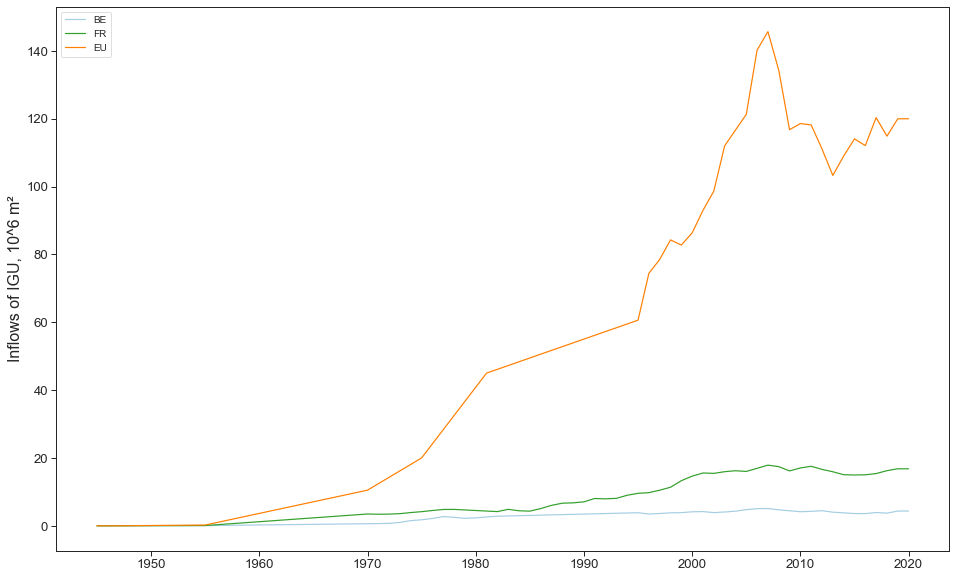

In [152]:
# select colors from the 'Paired' color map.
MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.3))

fig, ax = plt.subplots()

for m in range(0, len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
            Dyn_MFA_System.FlowDict['F_0_1'].Values[:, m, 0],
            color=MyColorCycle[m, :])

ax.set_ylabel('Inflows of IGU, 10^6 m²', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 10})

Plot the IGU stock in the different regions over time:

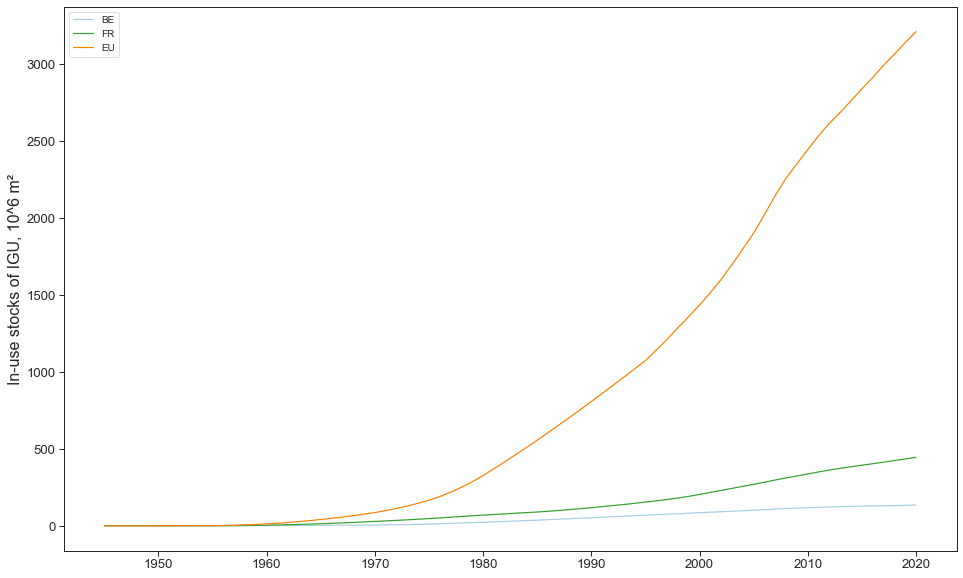

In [153]:
# select colors from the 'Paired' color map.
MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.3))

fig, ax = plt.subplots()

for m in range(0, len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
            Dyn_MFA_System.StockDict['S_1'].Values[:,:, m, 0].sum(axis=1),
            color=MyColorCycle[m, :])

ax.set_ylabel('In-use stocks of IGU, 10^6 m²', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 10})

Plot the ratio of outflow over inflow, which is a measure of the stationarity of a stock, and can be interpreted as one indicator for a 'circular economy':

C:\Users\souvi\Miniconda3\envs\PhD_Python\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


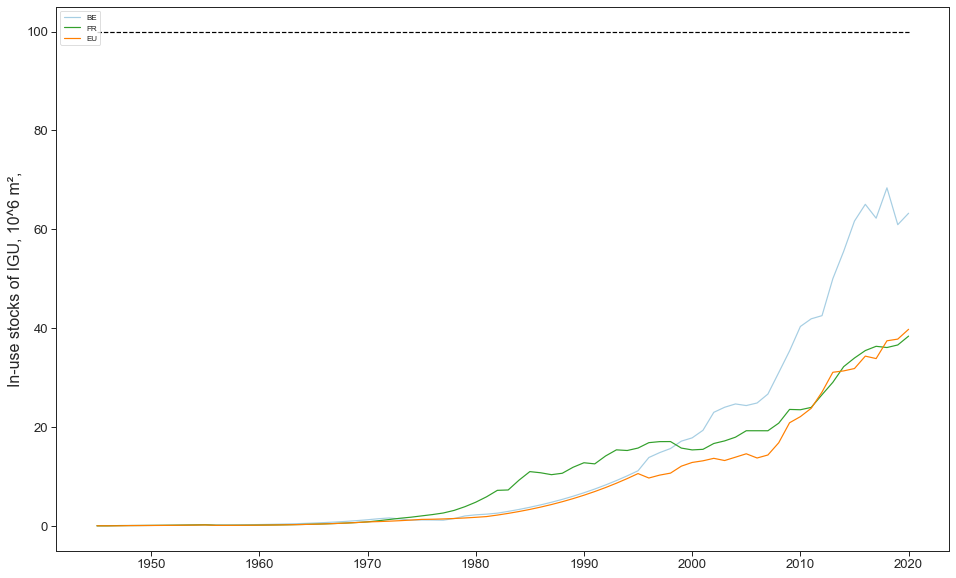

In [154]:
FlowRatio = Dyn_MFA_System.FlowDict['F_1_0'].Values[:, :, :, 0].sum(axis=1) \
    / Dyn_MFA_System.FlowDict['F_0_1'].Values[:, :, 0]

# Set all ratios where reference flow F_0_1 was zero to zero, not nan.
FlowRatio[np.isnan(FlowRatio)] = 0

fig, ax = plt.subplots()
for m in range(0, len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
            FlowRatio[:, m] * 100, color=MyColorCycle[m, :])

ax.plot([1945, 2020], [100, 100], color='k', linestyle='--')

ax.set_ylabel('In-use stocks of IGU, 10^6 m²,', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 8})

# Estimating the material content of the IGU stocks

See: docs/ "ODYM Example and Tutorial No. 5. MaterialContent_VehicleFleet"

Key question here: How big is the material stock currently embodied in the European/Belgian/French stock IGUs, and when will this material become available for recycling (or landfilling...)?

<font color='red'> The Excels files are all located in the folder: docs/Files/"_ODYM_***.xlsx". </font >

In [155]:
# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

INFO (<ipython-input-155-d52a9ccfdb65> <<module>>): ### 1. - Initialize.


## Export data to csv

<font color='red'>Dataframe for IGU consumption in [kt]:</font>

In [156]:
igu_use_kt = (pd.DataFrame({'Year': list(np.arange(1945, 2021))})
           .set_index('Year'))

In [157]:
igu_use_kt['EU'] = (eu_igu.droplevel(level=0)['Estimated consumption']
                    .drop(axis=1, columns='[10^6 m²]').reset_index()
                    .drop_duplicates(subset=['year'], keep='last')
                    .set_index('year'))

In [158]:
igu_use_kt['BE'] = be_fr_igu[('Estimated consumption',
                              '[kt]', 'Belgium')]

In [159]:
igu_use_kt['FR'] = be_fr_igu[('Estimated consumption',
                              '[kt]', 'France')]

In [161]:
igu_use_kt['Unit'] = '[kt]'

To copy paste in "_ODYM_IGU_EstimatedConsumption" Excel file, because for the moment I do not see a better method...

In [162]:
 igu_use_kt.interpolate().to_csv('IGU_EstimatedConsumption.csv')

##  Load Config file and read model control parameters

In [163]:
Mylog.info('### 2 - Load Config file and read model control parameters')

# Read main script parameters
# Load project-specific config file:
ProjectSpecs_Name_ConFile = '_ODYM_Config_IGU.xlsx'
Model_Configfile = xlrd.open_workbook(os.path.join(DataPath,
                                                   ProjectSpecs_Name_ConFile))

ScriptConfig = (
    {'Model Setting': (Model_Configfile.sheet_by_name('Config')
                       .cell_value(3, 3))}
)

Model_Configsheet = (
    Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario=Model_Configsheet.cell_value(3, 3)
print(Name_Scenario)

INFO (<ipython-input-163-4bed91ab4342> <<module>>): ### 2 - Load Config file and read model control parameters


ODYM_IGU


In [164]:
# Read model control parameters
# Read control and selection parameters into dictionary
SCix = 0
# search for script config list entry
while Model_Configsheet.cell_value(SCix, 1) != 'General Info':
    SCix += 1

SCix += 2  # start on first data row
while len(Model_Configsheet.cell_value(SCix, 3)) > 0:
    ScriptConfig[Model_Configsheet.cell_value(SCix, 2)] = (
        Model_Configsheet.cell_value(SCix, 3)
    )
    SCix += 1

SCix = 0
# search for script config list entry
while Model_Configsheet.cell_value(SCix, 1) != 'Software version selection':
    SCix += 1

SCix += 2  # start on first data row
while len(Model_Configsheet.cell_value(SCix, 3)) > 0:
    ScriptConfig[Model_Configsheet.cell_value(SCix, 2)] = (
        Model_Configsheet.cell_value(SCix, 3)
    )
    SCix += 1

print(ScriptConfig)

{'Model Setting': 'IGU', 'Name of model setting': 'ODYM_IGU', 'Description': 'Estimating the material composition of the European insulating glazing unit fleet', 'Name of model script used': 'ODYM_IGU_1', 'Version of master classification': '_ODYM_Classifications_IGU', 'Version of ODYM Classes': 'V01', 'Version of ODYM Functions': 'V01'}


 ## Read classification and data

In [165]:
Mylog.info('### 3 - Read classification and data')
# This is standard for each ODYM model run.

# Read model run config data
Classfile = xlrd.open_workbook(
    os.path.join(DataPath,
                 str(ScriptConfig['Version of master classification'])
                 + '.xlsx'))

Classsheet = Classfile.sheet_by_name('MAIN_Table')
ci = 1  # column index to start with
MasterClassification = {}  # Dict of master classifications
while True:
    TheseItems = []
    ri = 10  # row index to start with
    try:
        ThisName = Classsheet.cell_value(0, ci)
        ThisDim = Classsheet.cell_value(1, ci)
        ThisID = Classsheet.cell_value(3, ci)
        ThisUUID = Classsheet.cell_value(4, ci)
        # read the first classification item
        TheseItems.append(Classsheet.cell_value(ri, ci))
    except:
        print('End of file or formatting error while reading the classification file in column ' + str(ci) + '.')
        break
    while True:
        ri += 1
        try:
            ThisItem = Classsheet.cell_value(ri, ci)
        except:
            break
        if ThisItem is not '':
            TheseItems.append(ThisItem)
    MasterClassification[ThisName] = (
        msc.Classification(Name=ThisName, Dimension=ThisDim,
                           ID=ThisID, UUID=ThisUUID, Items=TheseItems))
    ci += 1

print('Read index table from model config sheet.')
ITix = 0
while True:  # search for index table entry
    if Model_Configsheet.cell_value(ITix, 1) == 'Index Table':
        break
    else:
        ITix += 1

IT_Aspects = []
IT_Description = []
IT_Dimension = []
IT_Classification = []
IT_Selector = []
IT_IndexLetter = []
ITix += 2  # start on first data row
while True:
    if len(Model_Configsheet.cell_value(ITix, 2)) > 0:
        IT_Aspects.append(Model_Configsheet.cell_value(ITix, 2))
        IT_Description.append(Model_Configsheet.cell_value(ITix, 3))
        IT_Dimension.append(Model_Configsheet.cell_value(ITix, 4))
        IT_Classification.append(Model_Configsheet.cell_value(ITix, 5))
        IT_Selector.append(Model_Configsheet.cell_value(ITix, 6))
        IT_IndexLetter.append(Model_Configsheet.cell_value(ITix, 7))
        ITix += 1
    else:
        break

print('Read parameter list from model config sheet.')
PLix = 0
while True:  # search for parameter list entry
    if Model_Configsheet.cell_value(PLix, 1) == 'Model Parameters':
        break
    else:
        PLix += 1

PL_Names = []
PL_Description = []
PL_Version = []
PL_IndexStructure = []
PL_IndexMatch = []
PL_IndexLayer = []
PLix += 2  # start on first data row
while True:
    if len(Model_Configsheet.cell_value(PLix, 2)) > 0:
        PL_Names.append(Model_Configsheet.cell_value(PLix, 2))
        PL_Description.append(Model_Configsheet.cell_value(PLix, 3))
        PL_Version.append(Model_Configsheet.cell_value(PLix, 4))
        PL_IndexStructure.append(Model_Configsheet.cell_value(PLix, 5))
        PL_IndexMatch.append(Model_Configsheet.cell_value(PLix, 6))
        # strip numbers out of list string
        PL_IndexLayer.append(msf.ListStringToListNumbers(
            Model_Configsheet.cell_value(PLix, 7)))
        PLix += 1
    else:
        break

print('Read process list from model config sheet.')
PrLix = 0
while True:  # search for process list entry
    if Model_Configsheet.cell_value(PrLix, 1) == 'Process Group List':
        break
    else:
        PrLix += 1

PrL_Number = []
PrL_Name = []
PrL_Code = []
PrL_Type = []
PrLix += 2  # start on first data row
while True:
    if Model_Configsheet.cell_value(PrLix, 2) != '':
        try:
            PrL_Number.append(int(Model_Configsheet.cell_value(PrLix, 2)))
        except:
            PrL_Number.append(Model_Configsheet.cell_value(PrLix, 2))
        PrL_Name.append(Model_Configsheet.cell_value(PrLix, 3))
        PrL_Code.append(Model_Configsheet.cell_value(PrLix, 4))
        PrL_Type.append(Model_Configsheet.cell_value(PrLix, 5))
        PrLix += 1
    else:
        break

print('Read model run control from model config sheet.')
PrLix = 0
while True:  # search for model flow control entry
    if Model_Configsheet.cell_value(PrLix, 1) == 'Model flow control':
        break
    else:
        PrLix += 1

PrLix += 2  # start on first data row
while True:
    if Model_Configsheet.cell_value(PrLix, 2) != '':
        try:
            ScriptConfig[Model_Configsheet.cell_value(PrLix, 2)] = (
                Model_Configsheet.cell_value(PrLix, 3))
        except:
            None
        PrLix += 1
    else:
        break

INFO (<ipython-input-165-da257f325e13> <<module>>): ### 3 - Read classification and data


End of file or formatting error while reading the classification file in column 11.
Read index table from model config sheet.
Read parameter list from model config sheet.
Read process list from model config sheet.
Read model run control from model config sheet.


In [167]:
print('Define model classifications and select items for model classifications according to information provided by config file.')

# Dict of model classifications
ModelClassification = {}

for m in range(0, len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(
        MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(
        IT_Selector[m], len(ModelClassification[IT_Aspects[m]].Items))

    if EvalString.find(':') > -1:  # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = (
            ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop])

    elif EvalString.find('[') > -1:  # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = (
            [ModelClassification[IT_Aspects[m]].Items[i]
                for i in eval(EvalString)])
        
    elif EvalString == 'all':
        None
    else:
        Mylog.info('ITEM SELECT ERROR for aspect ' +
                   IT_Aspects[m] + ' were found in datafile.</br>')
        break

Define model classifications and select items for model classifications according to information provided by config file.


IndexError: list index out of range

The following code block creates the index table for the MFA system and parses all parameter files specified into the parameter dictionary ParameterDict.

In [168]:
# Define model index table and parameter dictionary
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End = int(max(ModelClassification['Time'].Items))
Model_Duration = Model_Time_End - Model_Time_Start

Model_Duration

70

In [169]:
print('Define index table dataframe.')

IndexTable = pd.DataFrame(
    {'Aspect': IT_Aspects,
     # 'Time' and 'Element' must be present!
     'Description': IT_Description,
     'Dimension': IT_Dimension,
     'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
     # Unique one letter (upper or lower case) indices
     # to be used later for calculations.
     'IndexLetter': IT_IndexLetter}
)

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

Define index table dataframe.


KeyError: 'Waste_Scrap'

In [ ]:
# Add indexSize to IndexTable:
IndexTable['IndexSize'] = (
    pd.Series(
        [len(IndexTable.Classification[i].Items) for i in range(
            0, len(IndexTable.IndexLetter)
        )], index=IndexTable.index)
)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = (
    [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))])

In [178]:
# Define shortcuts for the most important index sizes:
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)

NR = len(IndexTable.Classification[IndexTable.set_index(
    'IndexLetter').index.get_loc('r')].Items)

NG = len(IndexTable.Classification[IndexTable.set_index(
    'IndexLetter').index.get_loc('g')].Items)

NM = len(IndexTable.Classification[IndexTable.set_index(
    'IndexLetter').index.get_loc('m')].Items)
print('Read model data and parameters.')

KeyError: 'g'

In [ ]:
ParameterDict = {}
for mo in range(0, len(PL_Names)):
    ParPath = os.path.join(DataPath, PL_Version[mo])
    print('Reading parameter ' + PL_Names[mo])
    # Do not change order of parameters handed over to function!
    MetaData, Values, Uncertainty = (
        msf.ReadParameterV2(ParPath, PL_Names[mo], PL_IndexStructure[mo],
                            PL_IndexMatch[mo], PL_IndexLayer[mo],
                            MasterClassification, IndexTable,
                            IndexTable_ClassificationNames,
                            ScriptConfig, Mylog, ParseUncertainty=True)
    )

    ParameterDict[PL_Names[mo]] = (
        msc.Parameter(Name=MetaData['Dataset_Name'],
                      ID=MetaData['Dataset_ID'],
                      UUID=MetaData['Dataset_UUID'],
                      P_Res=None,
                      MetaData=MetaData,
                      Indices=PL_IndexStructure[mo],
                      Values=Values,
                      Uncert=Uncertainty,
                      Unit=MetaData['Dataset_Unit'])
    )

In [170]:
# Replicate lifetime, given for 2020 age-cohort, for all age-cohorts
ParameterDict['_ODYM_IGULifetime'].Values[0, 0, :, :] = (
    np.einsum('r,c->rc', ParameterDict['_ODYM_IGULifetime']
              .Values[0, 0, :, 20], np.ones(Nt)))

# Replicate uncertainty
for m in range(0, NR):
    for n in range(0, Nt):
        ParameterDict['_ODYM_IGULifetime'].Uncert[m*Nt + n] = (
            ParameterDict['_ODYM_IGULifetime'].Uncert[m*Nt+20])

KeyError: '_ODYM_IGULifetime'

In [177]:
# Replicate IGU material content for all countries and age-cohorts:
ParameterDict['_ODYM_IGUMaterialContent'].Values[:, 0, :, :] = (
    np.einsum('m,rc->mrc', ParameterDict['_ODYM_IGUMaterialContent']
              .Values[:, 0, 0, 20], np.ones((NR, Nt)))
)

# Replicate uncertainty:
for m in range(0, NM):
    for r in range(0, NR):
        for t in range(0, Nt):
            (ParameterDict['_ODYM_IGUMaterialContent']
             .Uncert[m*Nt*NR + r*Nt + t]) = (
                ParameterDict['_ODYM_IGUMaterialContent']
                .Uncert[m*Nt*NR + 20])

KeyError: '_ODYM_IGUMaterialContent'

## Define MFA system

In [171]:
Mylog.info('### 4 - Define MFA system')
print('Define MFA system and processes.')

# Initialize MFA system
IGU_MFA_System = msc.MFAsystem(Name='Materials_IGU',
                               Geogr_Scope='Europe',
                               Unit='kt',
                               ProcessList=[],
                               FlowDict={},
                               StockDict={},
                               ParameterDict=ParameterDict,
                               Time_Start=Model_Time_Start,
                               Time_End=Model_Time_End,
                               IndexTable=IndexTable,
                               Elements=(IndexTable.loc['Element']
                                         .Classification.Items),
                               Graphical=None)

# Check Validity of index tables:
# returns true if dimensions are OK and time index is present and element list is not empty
IGU_MFA_System.IndexTableCheck()

INFO (<ipython-input-171-1e0de5f22d84> <<module>>): ### 4 - Define MFA system


Define MFA system and processes.


True

In [172]:
# Add processes to system
for m in range(0, len(PrL_Number)):
    IGU_MFA_System.ProcessList.append(
        msc.Process(Name=PrL_Name[m], ID=PrL_Number[m]))

In [173]:
# Define system variables: 6 flows.
IGU_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name='IGU production', 
                                            P_Start=0,
                                            P_End=1, 
                                            Indices='t,g,m,e',
                                            Values=None, Uncert=None, 
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_1_2'] = msc.Flow(Name='IGU consumption', 
                                            P_Start=1,
                                            P_End=2, Indices='t,g,r,m,e',
                                            Values=None, Uncert=None, 
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_2_3'] = msc.Flow(Name='Scrapping of IGU', 
                                            P_Start=2,
                                            P_End=3, Indices='t,c,g,r,m,e',
                                            Values=None, Uncert=None, 
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_3_4'] = msc.Flow(Name='IGU scrap', 
                                            P_Start=3,
                                            P_End=4, Indices='t,w,m,e',
                                            Values=None, Uncert=None, 
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_3_0'] = msc.Flow(Name='Recovery losses', 
                                            P_Start=3,
                                            P_End=0, Indices='t,m,e',
                                            Values=None, Uncert=None, 
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_4_0'] = msc.Flow(Name='IGU scrap supply', 
                                            P_Start=4,
                                            P_End=0, Indices='t,w,m,e',
                                            Values=None, Uncert=None, 
                                            Color=None,
                                            ID=None, UUID=None)

In [174]:
# Define system variables: 1 stock and 1 stock change:
IGU_MFA_System.StockDict['S_2'] = msc.Stock(Name='In-use stock', 
                                            P_Res=2, Type=0,
                                            Indices='t,c,g,r,m,e', 
                                            Values=None, Uncert=None,
                                            ID=None, UUID=None)

IGU_MFA_System.StockDict['dS_2'] = msc.Stock(Name='Net in-use stock change', 
                                             P_Res=2, Type=1,
                                             Indices='t,g,r,m,e', 
                                             Values=None, Uncert=None,
                                             ID=None, UUID=None)

In [175]:
# Assign empty arrays to stocks according to dimensions.
IGU_MFA_System.Initialize_StockValues()

# Assign empty arrays to flows according to dimensions.
IGU_MFA_System.Initialize_FlowValues()

KeyError: 'g'

In [176]:
IGU_MFA_System.IndexTable

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<ODYM_Classes.Classification object at 0x00000...,t
Age-cohort,"Model aspect ""age-cohort""",Time,<ODYM_Classes.Classification object at 0x00000...,c
Element,"Model aspect ""Element""",Element,<ODYM_Classes.Classification object at 0x00000...,e
Region,"Model aspect ""Region where flow occurs""",Region,<ODYM_Classes.Classification object at 0x00000...,r


In [ ]:
IGU_MFA_System.ParameterDict

In [ ]:
print(IGU_MFA_System.ProcessList)
print([i.Name for i in IGU_MFA_System.ProcessList])
print([i.ID for i in IGU_MFA_System.ProcessList])